In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score,auc
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import RandomOverSampler
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# Ytrain in Onehot encoded form 
def makeRandomOverSamples(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original training set shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    ros = RandomOverSampler(random_state=123)
    X_train, Y_train_labelled = ros.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [4]:
image_folder_path = '../../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


# Evaluation: Utility Functions

In [7]:
# onehot encoded Y_all
def kFold_train(X_all,Y_all, mode_version):
    from sklearn.model_selection import StratifiedKFold
    n_split=10
    n_classes=8

    y_all_labelled=[]
    for i in range(len(Y_all)):
            y_all_labelled.append(np.argmax(Y_all[i]))

    my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]

    count = 1

    for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
        # use the index to generate training an testing sets
        x_train,x_test=X_all[train_index],X_all[test_index]
        y_train,y_test=Y_all[train_index],Y_all[test_index]
        
        
       
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
        x_train, y_train= makeRandomOverSamples(x_train, y_train)

        # create and fit the model
        cv_model=build_current_model() # lr,dense,cnn
        history = cv_model.fit(x_train, y_train,
                  batch_size=8,
                  epochs=100,
                  validation_data= (x_val, y_val),
                  verbose=2,
                  callbacks=my_callbacks)


        file_name = mode_version +'_iter_' +str(count)
        
        
                
        #store test index
        csv_name= mode_version +'_testset_iter_' +str(count)
        test_index_df = pd.DataFrame(data=test_index,columns=["test_index"])
        with open(csv_name, mode='w') as f:
                 test_index_df.to_csv(f)
        #Store History
        hist_df = pd.DataFrame(history.history) 
        hist_json_file = file_name + '.json'

        with open(hist_json_file, mode='w') as f:
            hist_df.to_json(f)
            
            

        model_file = file_name + '.model'
        print(model_file)

        #Save Model
        cv_model.save(model_file) #Save the model

        count+=1

In [8]:
def kFold_test(X_all,Y_all, mode_version):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
    from sklearn.metrics import confusion_matrix

    n_split=10
    n_classes=8

    all_base_precision = list()
    all_base_recall = list()
    all_macro_precision = list()
    all_macro_recall = list()
    all_f1 = list()
    all_macro_f1 = list()

    all_tpr = list()
    all_fpr = list()
    all_precision = list()
    all_recall = list()
    all_cm=list()
    all_accuracy = list()

    all_df = list()

    y_all_labelled=[]
    for i in range(len(Y_all)):
            y_all_labelled.append(np.argmax(Y_all[i]))

    count = 1


    for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
        # use the index to generate training an testing sets
#         x_train,_=X_all[train_index],X_all[test_index]
#         y_train,y_test=Y_all[train_index],Y_all[test_index]


        file_name = mode_version +'_iter_' +str(count)
        csv_name= mode_version +'_testset_iter_' +str(count)
        #Load History 
        hist_json_file = file_name + '.json'
        history_info = pd.read_json(hist_json_file)
        all_df.append(history_info)


        # Load Model
        model_file = file_name + '.model'
        print('File Name Loaded: ',model_file)
        cv_model = tf.keras.models.load_model(model_file) 
        
        #load test set 
        testset_file= csv_name
        testset_df= pd.read_csv (testset_file)
        test_index=testset_df["test_index"].to_numpy()
       
        x_test=X_all[test_index]
        y_test=Y_all[test_index]


        count+=1

        #generate predictions
        y_pred = cv_model.predict(x_test)
        actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)

        #calc metrics
        curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
        curr_macro_prec = precision_score(actual, predicted,average='macro')
        curr_macro_rec = recall_score(actual, predicted,average='macro')
        curr_macro_f1 = f1_score(actual, predicted,average='macro')

        actual_labeled = list()
        predict_labeled = list()
        for x,y in zip(actual,predicted):
            actual_labeled.append(getSpecies(x))
            predict_labeled.append(getSpecies(y))

        labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)

        curr_fpr = [0] * n_classes
        curr_tpr = [0] * n_classes
        for i in range(n_classes):
            curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])

        curr_prec = [0] * n_classes
        curr_rec = [0] * n_classes
        for i in range(n_classes):
            curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])


        curr_accuracy = accuracy_score(actual, predicted)

        #add to lists
        all_base_precision.append(curr_base_prec)
        all_base_recall.append(curr_base_rec)
        all_macro_precision.append(curr_macro_prec)
        all_macro_recall.append(curr_macro_rec)

        all_f1.append(curr_f1)
        all_macro_f1.append(curr_macro_f1)

        all_accuracy.append(curr_accuracy)


        all_fpr.append(curr_fpr)
        all_tpr.append(curr_tpr)
        all_precision.append(curr_prec)
        all_recall.append(curr_rec)
        all_cm.append(curr_cm)
    kFold_metrics={
            "all_base_precision": all_base_precision ,
            "all_base_recall": all_base_recall,
            "all_macro_precision":all_macro_precision ,
            "all_macro_recall":all_macro_recall ,
            "all_f1":all_f1,
            "all_macro_f1":all_macro_f1 ,
        
            "all_accuracy":all_accuracy ,
            "all_fpr":all_fpr,
            "all_tpr": all_tpr,
            "all_precision":all_precision,
            "all_recall":all_recall,
            "all_cm": all_cm,
            "all_df":all_df
            
        }
    return kFold_metrics




In [9]:
def plot_loss_Accuracy(all_df):
    for df in all_df:
        _, axs = plt.subplots(ncols=2)

        sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
        sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

        sns.lineplot(data=df['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
        sns.lineplot(data=df['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [10]:
def print_metrics(KFold_metrics):
    print('precision mean by class', np.array(KFold_metrics.get("all_base_precision")).mean(axis=0))
    print('precision sdev by class', np.array(KFold_metrics.get("all_base_precision")).std(axis=0))

    print('macro precision mean', np.array(KFold_metrics.get("all_macro_precision")).mean())
    print('macro precision sdev', np.array(KFold_metrics.get("all_macro_precision")).std())


    print('recall mean', np.array(KFold_metrics.get("all_base_recall")).mean(axis=0))
    print('recall sdev', np.array(KFold_metrics.get("all_base_recall")).std(axis=0))

    print('macro recall mean', np.array(KFold_metrics.get("all_macro_recall")).mean())
    print('macro recall sdev', np.array(KFold_metrics.get("all_macro_recall")).std())

    print('f1 mean', np.array(KFold_metrics.get("all_f1")).mean(axis=0))
    print('f1 sdev', np.array(KFold_metrics.get("all_f1")).std(axis=0))

    print('macro f1 mean', np.array(KFold_metrics.get("all_macro_f1")).mean())
    print('macro f1 sdev', np.array(KFold_metrics.get("all_macro_f1")).std())

    print('accuracy mean', np.array(KFold_metrics.get("all_accuracy")).mean())
    print('accuracy sdev', np.array(KFold_metrics.get("all_accuracy")).std())



In [11]:
# Plot all K-Fold ROC curves
def plot_ROC(all_fpr,all_tpr,n_split=10, n_classes=8):
    for i in range(n_split):
        _, axs = plt.subplots(ncols=1)
        axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
        for j in range(n_classes):
            auc_val = auc(all_fpr[i][j], all_tpr[i][j])
            auc_val = np.around(auc_val,4)
            sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')


In [12]:
def print_meanAUC(all_fpr,all_tpr,n_split=10, n_classes=8):
    aucs = list()

    for i in range(n_classes):
        aucs.append(list())


    for i in range(n_split):
        for j in range(n_classes):
            auc_val = auc(all_fpr[i][j], all_tpr[i][j])
            aucs[j].append(auc_val)

    for i in range(n_classes):
        print("Sp: ", getSpecies(i))
        print("AUC Mean ", np.array(aucs[i]).mean())
        print("Std ", np.array(aucs[i]).std())

In [13]:
#Plot all K-Fold Precision/Recall curves
def plot_precision_recall(all_recall,all_precision,n_split=10, n_classes=8):
    for i in range(n_split):
        _, axs = plt.subplots(ncols=1)
        axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
        for j in range(n_classes):
            sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

In [14]:
def plot_confusion_matrices_per_iter(all_cm,n_split=10, n_classes=8):
    ## Plot all K-Fold confusion matrices
    import numpy as np
    import matplotlib.pylab as pl
    import matplotlib.gridspec as gridspec
    from matplotlib import pyplot as plt
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        
    # Create 1X 5 sub plots
    # gs = gridspec.GridSpec(1,n_split)
    figs=[]
    for i in range(n_split):
        figs.append(plt.figure())

    for i in range(n_split):
        print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
        print(all_cm[i])
        print("\n")

        ax=figs[i].add_subplot()
        sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells


        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
        ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [15]:
def  plot_macro_confusion_matrices(all_cm,n_split=10, n_classes=8):
    ## plot macro cm
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        
    sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
    for i in range(n_split):
        sum_all_cm+=all_cm[i]


    #plot 
    figs=[]
    for i in range(2):
        figs.append(plt.figure())

    print("sum of all confuion matrices\n",sum_all_cm)
    ax=figs[0].add_subplot()
    sns.heatmap(sum_all_cm, annot=True, ax = ax);

    avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
    print("\naverage of all confuion matrices\n",avg_all_cm)
    ax=figs[1].add_subplot()
    sns.heatmap(avg_all_cm, annot=True, ax = ax);
    return sum_all_cm, avg_all_cm

In [16]:
 def plot_normalised_confusion_matrix( sum_all_cm, avg_all_cm, n_split=10, n_classes=8):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        

    cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
    cm = (np.around(cm,2))
    print(cm)


    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

### Load and Evaluate



## V1 !!!!! K-Fold Training and Evaluation


In [17]:
folder = "models"
mode_version = "stft_RO_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/stft_RO_v1


In [18]:
def build_current_model():
    inp = inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120 ,kernel_size=(7,7),strides=(1,1),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=96,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1 ),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_out = Dense(8, name='output', activation='softmax')(f)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    return model



In [19]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 170, 120)     17760     
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 170, 120)     480       
_________________________________________________________________
activation (Activation)      (None, 112, 170, 120)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 85, 120)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 85, 120)       0         
_________

In [20]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 24s - loss: 1.6651 - acc: 0.3716 - val_loss: 1.4805 - val_acc: 0.2831
Epoch 2/100
9592/9592 - 23s - loss: 0.8687 - acc: 0.6699 - val_loss: 1.1007 - val_acc: 0.6103
Epoch 3/100
9592/9592 - 23s - loss: 0.3683 - acc: 0.8744 - val_loss: 0.4701 - val_acc: 0.8290
Epoch 4/100
9592/9592 - 23s - loss: 0.2292 - acc: 0.9232 - val_loss: 0.4653 - val_acc: 0.8382
Epoch 5/100
9592/9592 - 23s - loss: 0.1659 - acc: 0.9442 - val_loss: 0.3097 - val_acc: 0.9

Epoch 25/100
9592/9592 - 23s - loss: 0.0363 - acc: 0.9900 - val_loss: 0.4437 - val_acc: 0.9044
Epoch 26/100
9592/9592 - 24s - loss: 0.0241 - acc: 0.9931 - val_loss: 0.1148 - val_acc: 0.9632
Epoch 27/100
9592/9592 - 24s - loss: 0.0418 - acc: 0.9886 - val_loss: 0.2247 - val_acc: 0.9430
Epoch 28/100
9592/9592 - 24s - loss: 0.0236 - acc: 0.9927 - val_loss: 0.1484 - val_acc: 0.9559
Epoch 29/100
9592/9592 - 23s - loss: 0.0317 - acc: 0.9900 - val_loss: 0.2027 - val_acc: 0.9559
Epoch 30/100
9592/9592 - 23s - loss: 0.0263 - acc: 0.9928 - val_loss: 0.1260 - val_acc: 0.9632
Epoch 31/100
9592/9592 - 24s - loss: 0.0257 - acc: 0.9929 - val_loss: 0.9071 - val_acc: 0.8309
Epoch 32/100
9592/9592 - 23s - loss: 0.0227 - acc: 0.9930 - val_loss: 0.2270 - val_acc: 0.9485
Epoch 33/100
9592/9592 - 24s - loss: 0.0132 - acc: 0.9960 - val_loss: 0.1675 - val_acc: 0.9577
Epoch 34/100
9592/9592 - 24s - loss: 0.0372 - acc: 0.9898 - val_loss: 0.1628 - val_acc: 0.9504
Epoch 35/100
9592/9592 - 24s - loss: 0.0260 - acc:

Epoch 8/100
9584/9584 - 24s - loss: 0.0786 - acc: 0.9738 - val_loss: 0.3427 - val_acc: 0.8842
Epoch 9/100
9584/9584 - 24s - loss: 0.0712 - acc: 0.9769 - val_loss: 0.3852 - val_acc: 0.8768
Epoch 10/100
9584/9584 - 24s - loss: 0.0664 - acc: 0.9794 - val_loss: 0.3938 - val_acc: 0.8824
Epoch 11/100
9584/9584 - 24s - loss: 0.0490 - acc: 0.9849 - val_loss: 1.6287 - val_acc: 0.7537
Epoch 12/100
9584/9584 - 24s - loss: 0.0522 - acc: 0.9838 - val_loss: 0.2874 - val_acc: 0.9007
Epoch 13/100
9584/9584 - 24s - loss: 0.0605 - acc: 0.9821 - val_loss: 0.4381 - val_acc: 0.8860
Epoch 14/100
9584/9584 - 24s - loss: 0.0381 - acc: 0.9879 - val_loss: 0.5339 - val_acc: 0.8327
Epoch 15/100
9584/9584 - 24s - loss: 0.0461 - acc: 0.9869 - val_loss: 0.3931 - val_acc: 0.9044
Epoch 16/100
9584/9584 - 24s - loss: 0.0374 - acc: 0.9881 - val_loss: 3.5871 - val_acc: 0.6121
Epoch 17/100
9584/9584 - 24s - loss: 0.0438 - acc: 0.9883 - val_loss: 0.6998 - val_acc: 0.7574
Epoch 18/100
9584/9584 - 24s - loss: 0.0365 - acc: 0

Epoch 4/100
9584/9584 - 24s - loss: 0.1780 - acc: 0.9413 - val_loss: 0.4063 - val_acc: 0.8713
Epoch 5/100
9584/9584 - 24s - loss: 0.1370 - acc: 0.9541 - val_loss: 0.9809 - val_acc: 0.6985
Epoch 6/100
9584/9584 - 24s - loss: 0.1271 - acc: 0.9588 - val_loss: 1.1023 - val_acc: 0.6471
Epoch 7/100
9584/9584 - 24s - loss: 0.0915 - acc: 0.9710 - val_loss: 0.4346 - val_acc: 0.8456
Epoch 8/100
9584/9584 - 24s - loss: 0.0835 - acc: 0.9737 - val_loss: 4.4043 - val_acc: 0.4393
Epoch 9/100
9584/9584 - 24s - loss: 0.0774 - acc: 0.9774 - val_loss: 1.1914 - val_acc: 0.7739
Epoch 10/100
9584/9584 - 24s - loss: 0.0599 - acc: 0.9825 - val_loss: 0.3685 - val_acc: 0.8842
Epoch 11/100
9584/9584 - 24s - loss: 0.0608 - acc: 0.9824 - val_loss: 0.2347 - val_acc: 0.9301
Epoch 12/100
9584/9584 - 24s - loss: 0.0461 - acc: 0.9865 - val_loss: 0.2331 - val_acc: 0.9357
Epoch 13/100
9584/9584 - 24s - loss: 0.0536 - acc: 0.9838 - val_loss: 1.3326 - val_acc: 0.7831
Epoch 14/100
9584/9584 - 24s - loss: 0.0438 - acc: 0.987

Epoch 6/100
9584/9584 - 24s - loss: 0.1176 - acc: 0.9631 - val_loss: 0.2557 - val_acc: 0.9173
Epoch 7/100
9584/9584 - 24s - loss: 0.1019 - acc: 0.9684 - val_loss: 0.2398 - val_acc: 0.9026
Epoch 8/100
9584/9584 - 25s - loss: 0.0771 - acc: 0.9757 - val_loss: 1.2909 - val_acc: 0.7739
Epoch 9/100
9584/9584 - 25s - loss: 0.0741 - acc: 0.9775 - val_loss: 0.4189 - val_acc: 0.8695
Epoch 10/100
9584/9584 - 24s - loss: 0.0815 - acc: 0.9745 - val_loss: 0.2496 - val_acc: 0.9283
Epoch 11/100
9584/9584 - 24s - loss: 0.0577 - acc: 0.9803 - val_loss: 0.6269 - val_acc: 0.8640
Epoch 12/100
9584/9584 - 24s - loss: 0.0532 - acc: 0.9842 - val_loss: 0.2351 - val_acc: 0.9173
Epoch 13/100
9584/9584 - 24s - loss: 0.0514 - acc: 0.9826 - val_loss: 0.2860 - val_acc: 0.9099
Epoch 14/100
9584/9584 - 24s - loss: 0.0523 - acc: 0.9849 - val_loss: 0.2553 - val_acc: 0.9228
Epoch 15/100
9584/9584 - 24s - loss: 0.0445 - acc: 0.9871 - val_loss: 0.2743 - val_acc: 0.9357
Epoch 16/100
9584/9584 - 24s - loss: 0.0368 - acc: 0.9

Epoch 26/100
9592/9592 - 24s - loss: 0.0259 - acc: 0.9929 - val_loss: 0.3976 - val_acc: 0.9044
Epoch 27/100
9592/9592 - 24s - loss: 0.0407 - acc: 0.9879 - val_loss: 0.2034 - val_acc: 0.9651
Epoch 28/100
9592/9592 - 24s - loss: 0.0141 - acc: 0.9954 - val_loss: 0.2846 - val_acc: 0.9210
Epoch 29/100
9592/9592 - 24s - loss: 0.0293 - acc: 0.9900 - val_loss: 0.1717 - val_acc: 0.9651
Epoch 30/100
9592/9592 - 24s - loss: 0.0268 - acc: 0.9932 - val_loss: 0.3009 - val_acc: 0.9596
Epoch 31/100
9592/9592 - 24s - loss: 0.0223 - acc: 0.9936 - val_loss: 0.2506 - val_acc: 0.9393
Epoch 32/100
9592/9592 - 24s - loss: 0.0302 - acc: 0.9919 - val_loss: 0.2604 - val_acc: 0.9467
Epoch 33/100
9592/9592 - 24s - loss: 0.0298 - acc: 0.9923 - val_loss: 0.3366 - val_acc: 0.9375
Epoch 34/100
9592/9592 - 24s - loss: 0.0316 - acc: 0.9913 - val_loss: 0.3205 - val_acc: 0.9154
Epoch 35/100
9592/9592 - 24s - loss: 0.0165 - acc: 0.9953 - val_loss: 0.2467 - val_acc: 0.9669
Epoch 36/100
9592/9592 - 24s - loss: 0.0265 - acc:

Epoch 00062: early stopping
models/stft_RO_v1_iter_10.model


In [21]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/stft_RO_v1_iter_1.model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
File Name Loaded:  models/stft_RO_v1_iter_2.model
File Name Loaded:  models/stft_RO_v1_iter_3.model
File Name Loaded:  models/stft_RO_v1_iter_4.model
File Name Loaded:  models/stft_RO_v1_iter_5.model
File Name Loaded:  models/stft_RO_v1_iter_6.model
File Name Loaded:  models/stft_RO_v1_iter_7.model
File Name Loaded:  models/stft_RO_v1_iter_8.model
File Name Loaded:  models/stft_RO_v1_iter_9.model
File Name Loaded:  models/stft_RO_v1_iter_10.model


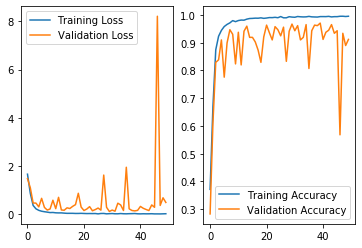

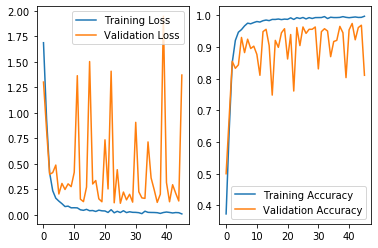

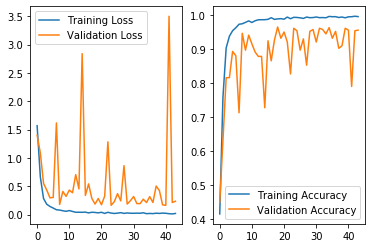

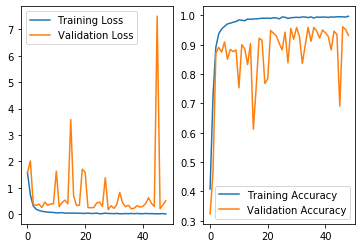

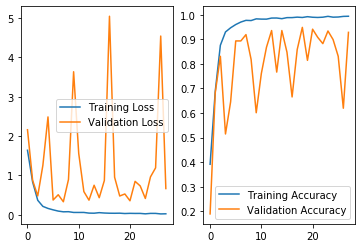

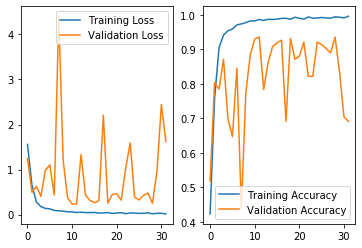

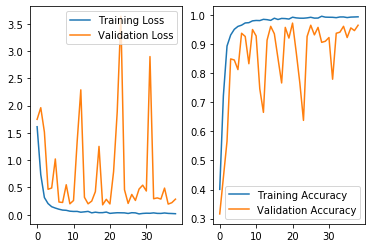

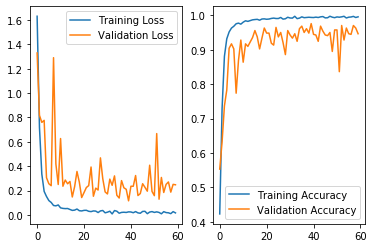

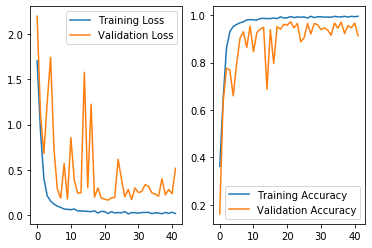

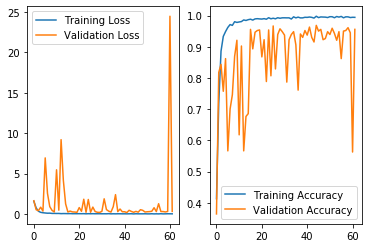

In [22]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [23]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.90549451 0.83814394 0.92003251 0.98725592 0.97112222
 0.8002952  0.89038245]
precision sdev by class [0.         0.10544728 0.12890837 0.04845085 0.0115183  0.03192509
 0.08999267 0.04195415]
macro precision mean 0.9140908413640826
macro precision sdev 0.03500051944926163
recall mean [0.96666667 0.92820513 0.80227273 0.94977011 0.96998413 0.86623932
 0.94166667 0.9402439 ]
recall sdev [0.1        0.06586051 0.15183489 0.05828402 0.01035103 0.06444181
 0.05335937 0.04498992]
macro recall mean 0.9206310813201677
macro recall sdev 0.031964248412121775
f1 mean [0.98       0.91205724 0.81080661 0.93238016 0.97849791 0.9144964
 0.86223854 0.91421515]
f1 sdev [0.06       0.06645537 0.12388515 0.0300257  0.00868638 0.04286757
 0.05750253 0.03904328]
macro f1 mean 0.9130865005687664
macro f1 sdev 0.035578046281076685
accuracy mean 0.945654661063563
accuracy sdev 0.021133118182784957


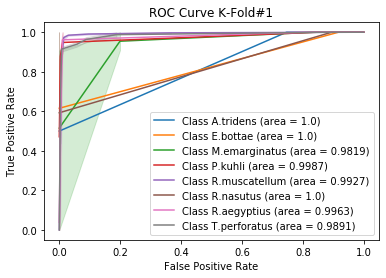

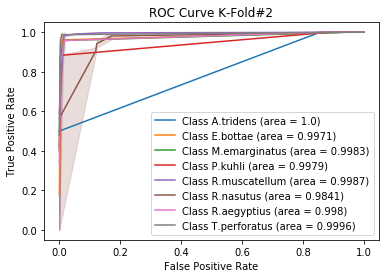

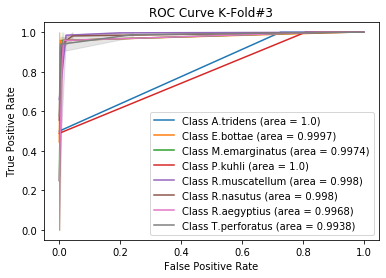

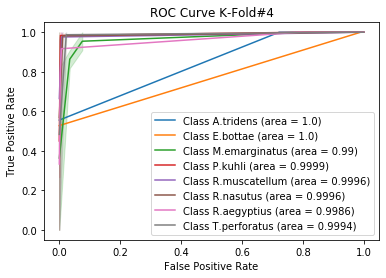

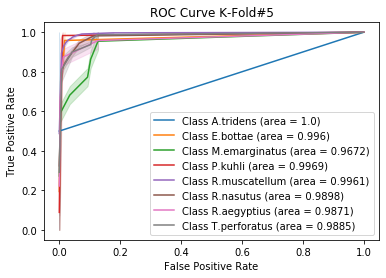

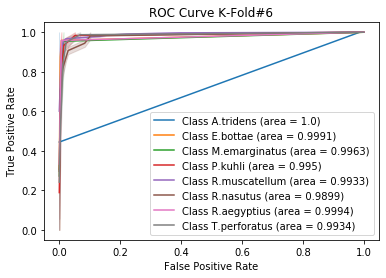

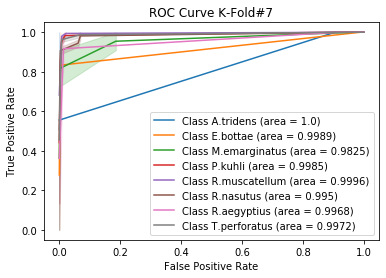

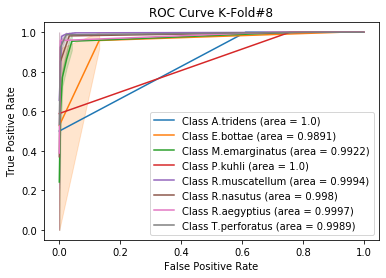

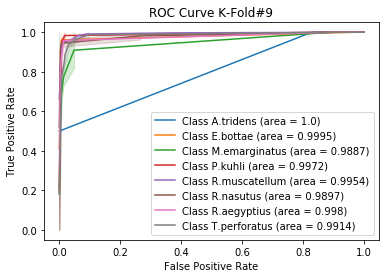

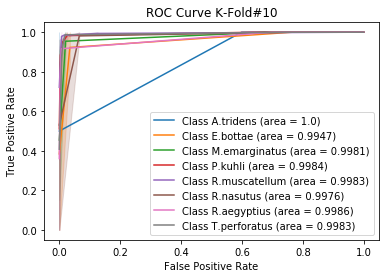

In [24]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [25]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9973954684333816
Std  0.0032730004114323377
Sp:  M.emarginatus
AUC Mean  0.9892551627185471
Std  0.009334804168200383
Sp:  P.kuhli
AUC Mean  0.9982605645740831
Std  0.0015068237295557277
Sp:  R.muscatellum
AUC Mean  0.9971323344727192
Std  0.0024474847916390687
Sp:  R.nasutus
AUC Mean  0.9941643265816543
Std  0.005130653788928706
Sp:  R.aegyptius
AUC Mean  0.9969250196567939
Std  0.003452556363659293
Sp:  T.perforatus
AUC Mean  0.9949661086108097
Std  0.004066529832350503


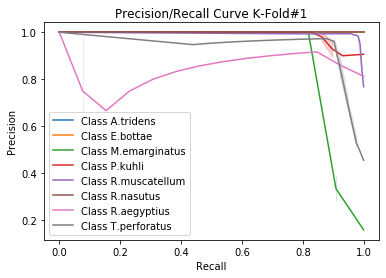

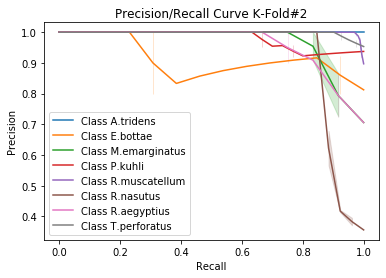

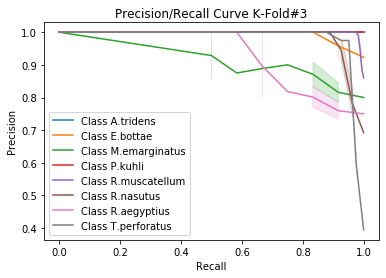

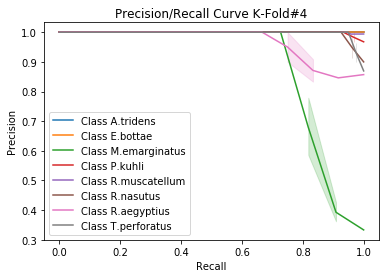

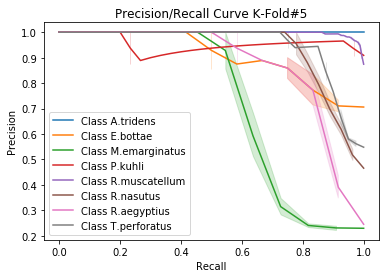

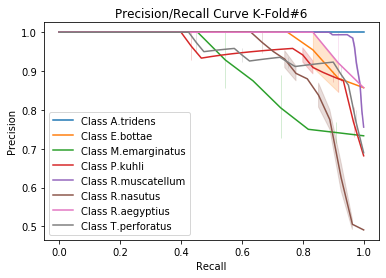

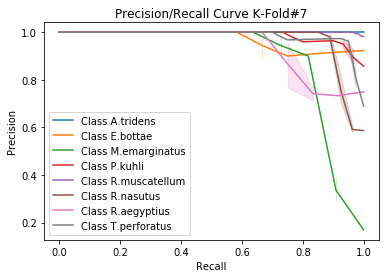

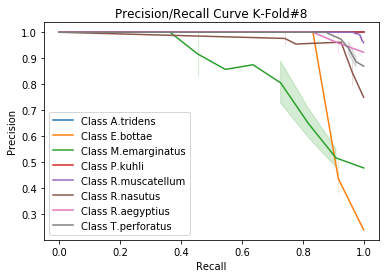

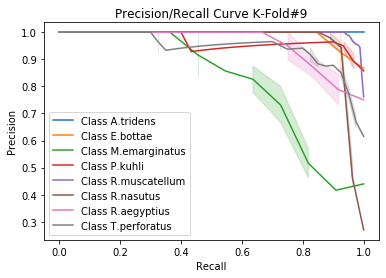

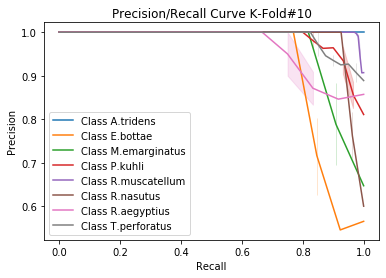

In [26]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  10   0   0   0   1   0]
 [  0   0   0  27   1   0   0   1]
 [  0   0   0   0 163   0   0   3]
 [  0   0   0   3   0  23   1   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   2   0   1  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   1   1   0   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   0  29   0   0   0   1]
 [  0   0   1   0 162   0   1   2]
 [  0   1   0   2   0  23   0   0]
 [  0   0   0   0   1   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0  10   0   0   0   1   1]
 [  0   0   0  27   0   1   0   2]
 [  0   0   0   0 161   0   2   3]
 [  0   0   1   0   0  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   1   0   0   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

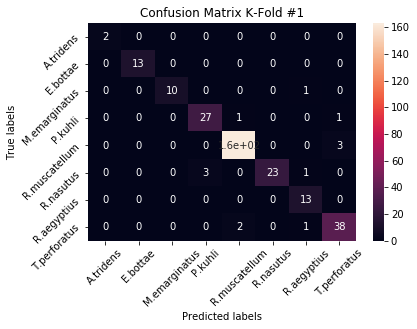

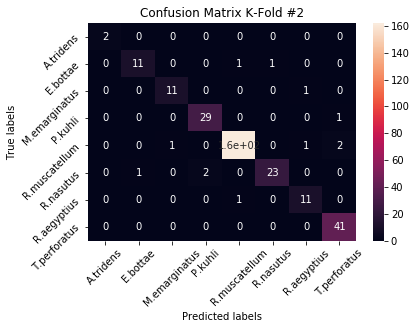

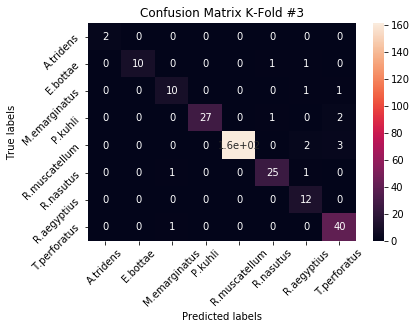

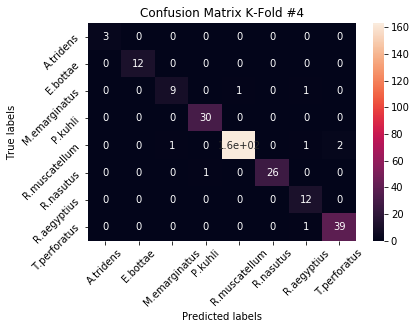

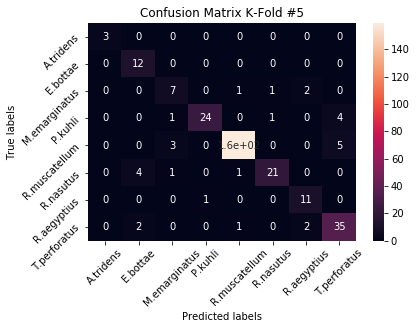

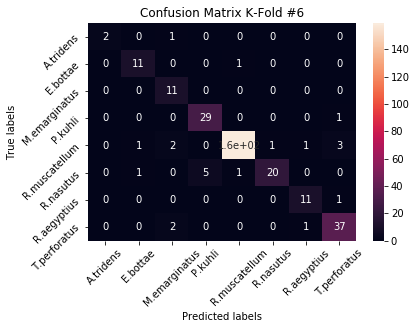

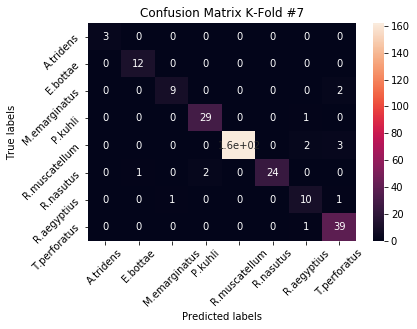

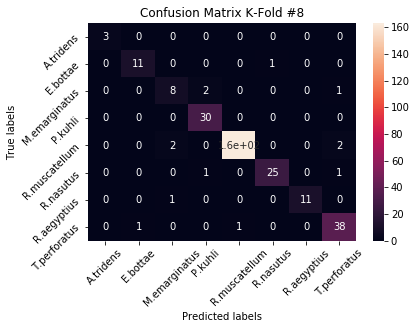

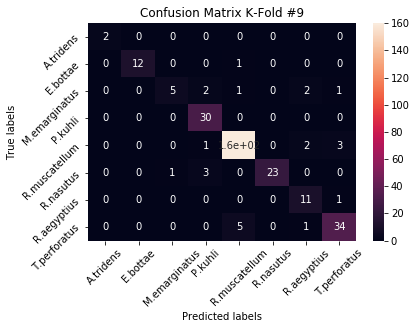

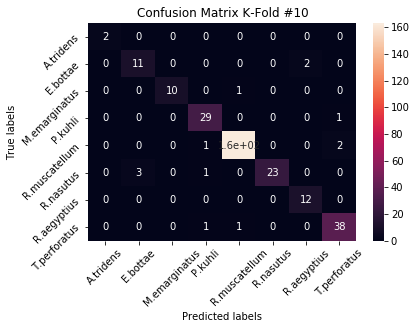

In [27]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  24    0    1    0    0    0    0    0]
 [   0  115    0    0    3    3    3    0]
 [   0    0   90    4    4    1    8    5]
 [   0    0    1  284    1    2    1   10]
 [   0    1    9    2 1615    1    9   28]
 [   0   10    3   18    2  233    2    1]
 [   0    0    2    1    1    0  114    3]
 [   0    3    3    1   10    0    7  379]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   1]
 [  0   0   0   0 161   0   0   2]
 [  0   1   0   1   0  23   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  37]]


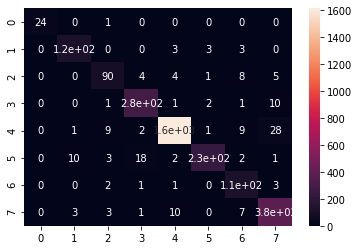

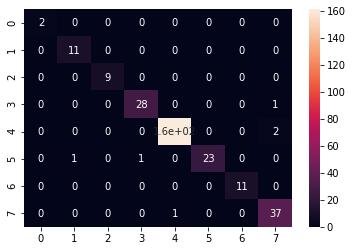

In [28]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.96 0.   0.04 0.   0.   0.   0.   0.  ]
 [0.   0.93 0.   0.   0.02 0.02 0.02 0.  ]
 [0.   0.   0.8  0.04 0.04 0.01 0.07 0.04]
 [0.   0.   0.   0.95 0.   0.01 0.   0.03]
 [0.   0.   0.01 0.   0.97 0.   0.01 0.02]
 [0.   0.04 0.01 0.07 0.01 0.87 0.01 0.  ]
 [0.   0.   0.02 0.01 0.01 0.   0.94 0.02]
 [0.   0.01 0.01 0.   0.02 0.   0.02 0.94]]


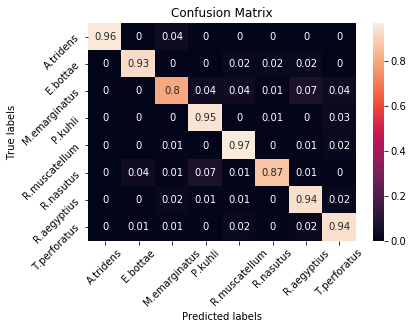

In [29]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V2 !!!!! K-Fold Training and Evaluation</h2>

In [30]:
folder = "models"
mode_version = "stft_RO_v2"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/stft_RO_v2


In [31]:

def build_current_model():
    inp = inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120 ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=96,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_out = Dense(8, name='output', activation='softmax')(f)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    return model






In [32]:
model = build_current_model()
model.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization_44 (Batc (None, 56, 85, 120)       480       
_________________________________________________________________
activation_44 (Activation)   (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 22, 96)        288

In [33]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 15s - loss: 1.4281 - acc: 0.4638 - val_loss: 1.0516 - val_acc: 0.6305
Epoch 2/100
9592/9592 - 14s - loss: 0.5940 - acc: 0.7809 - val_loss: 1.0123 - val_acc: 0.6379
Epoch 3/100
9592/9592 - 14s - loss: 0.3467 - acc: 0.8798 - val_loss: 0.6873 - val_acc: 0.7261
Epoch 4/100
9592/9592 - 14s - loss: 0.2443 - acc: 0.9210 - val_loss: 0.5636 - val_acc: 0.8217
Epoch 5/100
9592/9592 - 14s - loss: 0.1970 - acc: 0.9347 - val_loss: 0.4401 - val_acc: 0.8

Epoch 32/100
9592/9592 - 13s - loss: 0.0286 - acc: 0.9917 - val_loss: 0.2231 - val_acc: 0.9449
Epoch 33/100
9592/9592 - 12s - loss: 0.0371 - acc: 0.9898 - val_loss: 0.3006 - val_acc: 0.9173
Epoch 34/100
9592/9592 - 13s - loss: 0.0239 - acc: 0.9929 - val_loss: 0.1313 - val_acc: 0.9614
Epoch 35/100
9592/9592 - 12s - loss: 0.0286 - acc: 0.9926 - val_loss: 0.7015 - val_acc: 0.8438
Epoch 36/100
9592/9592 - 13s - loss: 0.0285 - acc: 0.9917 - val_loss: 0.1306 - val_acc: 0.9596
Epoch 37/100
9592/9592 - 12s - loss: 0.0294 - acc: 0.9925 - val_loss: 0.5649 - val_acc: 0.8529
Epoch 38/100
9592/9592 - 12s - loss: 0.0321 - acc: 0.9897 - val_loss: 0.2791 - val_acc: 0.9246
Epoch 39/100
9592/9592 - 13s - loss: 0.0274 - acc: 0.9925 - val_loss: 0.5513 - val_acc: 0.8511
Epoch 40/100
9592/9592 - 12s - loss: 0.0269 - acc: 0.9928 - val_loss: 0.4059 - val_acc: 0.9007
Epoch 41/100
9592/9592 - 13s - loss: 0.0238 - acc: 0.9925 - val_loss: 0.6221 - val_acc: 0.7684
Epoch 42/100
9592/9592 - 12s - loss: 0.0201 - acc:

Epoch 42/100
9592/9592 - 13s - loss: 0.0289 - acc: 0.9919 - val_loss: 0.2074 - val_acc: 0.9430
Epoch 43/100
9592/9592 - 13s - loss: 0.0232 - acc: 0.9915 - val_loss: 0.3072 - val_acc: 0.9320
Epoch 44/100
9592/9592 - 13s - loss: 0.0203 - acc: 0.9944 - val_loss: 0.1628 - val_acc: 0.9596
Epoch 45/100
9592/9592 - 13s - loss: 0.0194 - acc: 0.9942 - val_loss: 0.1368 - val_acc: 0.9706
Epoch 46/100
9592/9592 - 13s - loss: 0.0166 - acc: 0.9944 - val_loss: 1.3951 - val_acc: 0.7574
Epoch 47/100
9592/9592 - 13s - loss: 0.0378 - acc: 0.9902 - val_loss: 0.2800 - val_acc: 0.9522
Epoch 48/100
9592/9592 - 13s - loss: 0.0195 - acc: 0.9950 - val_loss: 0.1346 - val_acc: 0.9614
Epoch 49/100
9592/9592 - 13s - loss: 0.0353 - acc: 0.9915 - val_loss: 0.2104 - val_acc: 0.9412
Epoch 50/100
9592/9592 - 13s - loss: 0.0133 - acc: 0.9964 - val_loss: 0.2349 - val_acc: 0.9577
Epoch 51/100
9592/9592 - 13s - loss: 0.0299 - acc: 0.9923 - val_loss: 0.2445 - val_acc: 0.9320
Epoch 52/100
9592/9592 - 13s - loss: 0.0134 - acc:

Epoch 25/100
9584/9584 - 12s - loss: 0.0424 - acc: 0.9869 - val_loss: 0.4331 - val_acc: 0.8750
Epoch 26/100
9584/9584 - 12s - loss: 0.0350 - acc: 0.9893 - val_loss: 0.2866 - val_acc: 0.9338
Epoch 27/100
9584/9584 - 12s - loss: 0.0430 - acc: 0.9872 - val_loss: 0.3411 - val_acc: 0.9062
Epoch 28/100
9584/9584 - 12s - loss: 0.0335 - acc: 0.9900 - val_loss: 0.2296 - val_acc: 0.9449
Epoch 29/100
9584/9584 - 12s - loss: 0.0364 - acc: 0.9891 - val_loss: 0.2369 - val_acc: 0.9320
Epoch 30/100
9584/9584 - 12s - loss: 0.0289 - acc: 0.9921 - val_loss: 0.2836 - val_acc: 0.9375
Epoch 31/100
9584/9584 - 12s - loss: 0.0295 - acc: 0.9908 - val_loss: 0.5349 - val_acc: 0.9007
Epoch 32/100
9584/9584 - 12s - loss: 0.0311 - acc: 0.9922 - val_loss: 0.2084 - val_acc: 0.9559
Epoch 33/100
Restoring model weights from the end of the best epoch.
9584/9584 - 13s - loss: 0.0326 - acc: 0.9909 - val_loss: 0.2231 - val_acc: 0.9449
Epoch 00033: early stopping
models/stft_RO_v2_iter_6.model
Original training set shape [(

Epoch 19/100
9584/9584 - 12s - loss: 0.0520 - acc: 0.9845 - val_loss: 2.3790 - val_acc: 0.5331
Epoch 20/100
9584/9584 - 12s - loss: 0.0587 - acc: 0.9825 - val_loss: 0.2905 - val_acc: 0.9099
Epoch 21/100
9584/9584 - 13s - loss: 0.0420 - acc: 0.9875 - val_loss: 0.1094 - val_acc: 0.9614
Epoch 22/100
9584/9584 - 13s - loss: 0.0402 - acc: 0.9863 - val_loss: 0.3730 - val_acc: 0.8787
Epoch 23/100
9584/9584 - 12s - loss: 0.0519 - acc: 0.9842 - val_loss: 0.4881 - val_acc: 0.8787
Epoch 24/100
9584/9584 - 12s - loss: 0.0317 - acc: 0.9897 - val_loss: 0.3514 - val_acc: 0.8879
Epoch 25/100
9584/9584 - 12s - loss: 0.0416 - acc: 0.9884 - val_loss: 0.1406 - val_acc: 0.9596
Epoch 26/100
9584/9584 - 12s - loss: 0.0399 - acc: 0.9886 - val_loss: 0.3789 - val_acc: 0.8824
Epoch 27/100
9584/9584 - 12s - loss: 0.0362 - acc: 0.9899 - val_loss: 0.2092 - val_acc: 0.9485
Epoch 28/100
9584/9584 - 13s - loss: 0.0340 - acc: 0.9905 - val_loss: 0.4691 - val_acc: 0.8309
Epoch 29/100
9584/9584 - 13s - loss: 0.0389 - acc:

Epoch 37/100
9592/9592 - 13s - loss: 0.0375 - acc: 0.9894 - val_loss: 0.2305 - val_acc: 0.9504
Epoch 38/100
9592/9592 - 12s - loss: 0.0314 - acc: 0.9907 - val_loss: 0.2021 - val_acc: 0.9559
Epoch 39/100
9592/9592 - 12s - loss: 0.0224 - acc: 0.9930 - val_loss: 0.3983 - val_acc: 0.9099
Epoch 40/100
9592/9592 - 12s - loss: 0.0377 - acc: 0.9898 - val_loss: 0.2616 - val_acc: 0.9393
Epoch 41/100
9592/9592 - 12s - loss: 0.0236 - acc: 0.9935 - val_loss: 0.2873 - val_acc: 0.9357
Epoch 42/100
9592/9592 - 13s - loss: 0.0258 - acc: 0.9928 - val_loss: 0.2295 - val_acc: 0.9467
Epoch 43/100
9592/9592 - 13s - loss: 0.0275 - acc: 0.9910 - val_loss: 0.5642 - val_acc: 0.8493
Epoch 44/100
9592/9592 - 12s - loss: 0.0166 - acc: 0.9948 - val_loss: 2.8049 - val_acc: 0.6397
Epoch 45/100
9592/9592 - 12s - loss: 0.0282 - acc: 0.9912 - val_loss: 0.3839 - val_acc: 0.8952
Epoch 46/100
9592/9592 - 12s - loss: 0.0254 - acc: 0.9923 - val_loss: 0.2839 - val_acc: 0.9430
Epoch 47/100
9592/9592 - 13s - loss: 0.0258 - acc:

In [34]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/stft_RO_v2_iter_1.model
File Name Loaded:  models/stft_RO_v2_iter_2.model
File Name Loaded:  models/stft_RO_v2_iter_3.model
File Name Loaded:  models/stft_RO_v2_iter_4.model
File Name Loaded:  models/stft_RO_v2_iter_5.model
File Name Loaded:  models/stft_RO_v2_iter_6.model
File Name Loaded:  models/stft_RO_v2_iter_7.model
File Name Loaded:  models/stft_RO_v2_iter_8.model
File Name Loaded:  models/stft_RO_v2_iter_9.model
File Name Loaded:  models/stft_RO_v2_iter_10.model


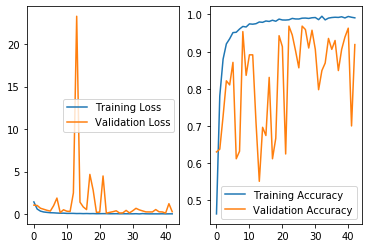

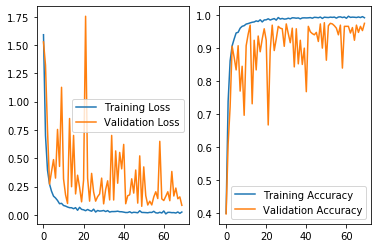

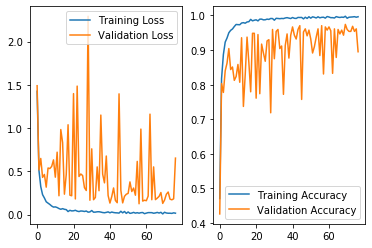

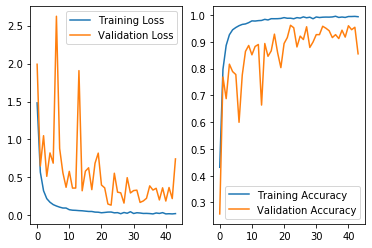

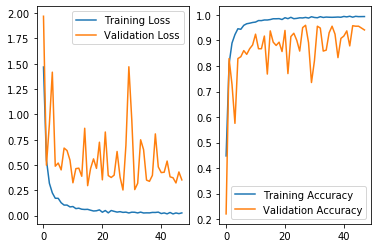

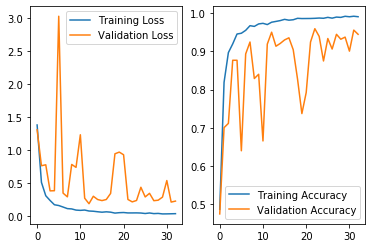

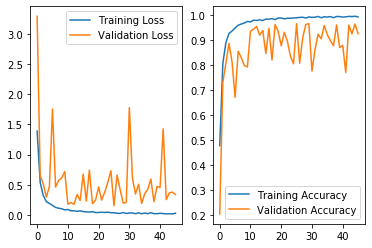

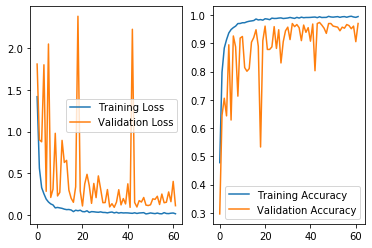

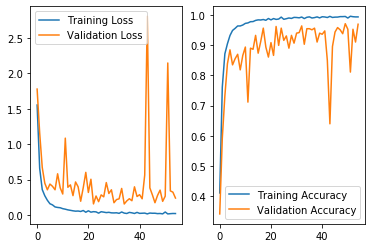

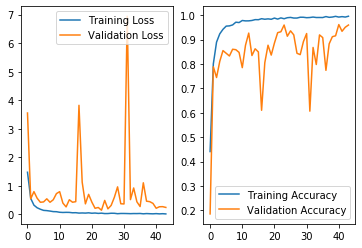

In [35]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [36]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.93559774 0.82539821 0.93663439 0.98798538 0.96146988
 0.85637862 0.92104206]
precision sdev by class [0.         0.05897452 0.1320834  0.04892627 0.01061121 0.02988081
 0.09566048 0.06011104]
macro precision mean 0.9280632846714909
macro precision sdev 0.025485494684440974
recall mean [0.93333333 0.92115385 0.81969697 0.94666667 0.97776495 0.91809117
 0.89358974 0.9602439 ]
recall sdev [0.2        0.07830227 0.09246149 0.04268749 0.0152299  0.04022672
 0.12180162 0.02540393]
macro recall mean 0.921317572749302
macro recall sdev 0.0234251224626359
f1 mean [0.95       0.92693088 0.8128168  0.94056168 0.98275358 0.93879655
 0.86608961 0.93902962]
f1 sdev [0.15       0.05973598 0.0659044  0.03415877 0.00900414 0.02861073
 0.07020525 0.03428762]
macro f1 mean 0.9196223393565115
macro f1 sdev 0.024399204180701475
accuracy mean 0.9549239840707575
accuracy sdev 0.013408166275378311


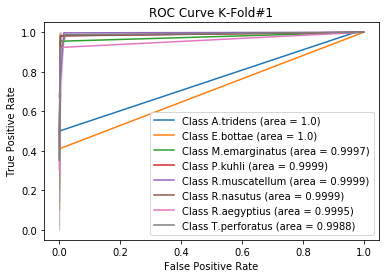

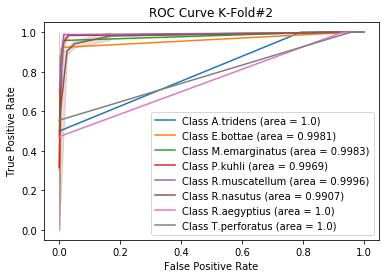

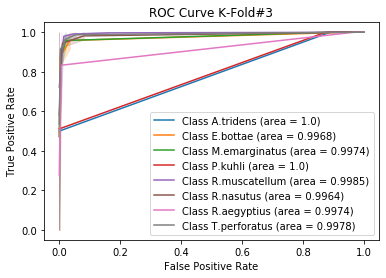

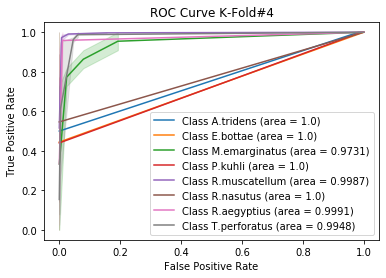

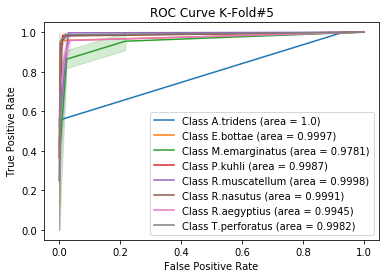

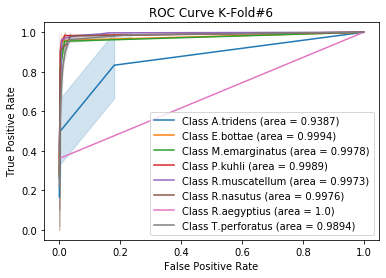

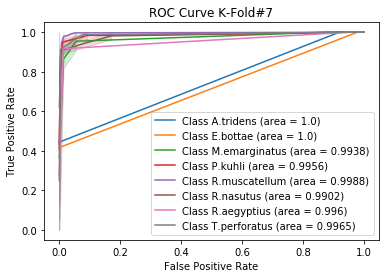

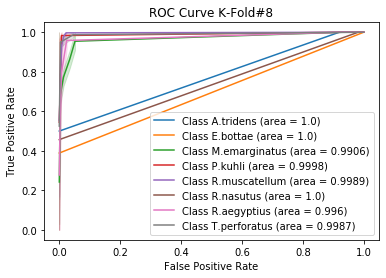

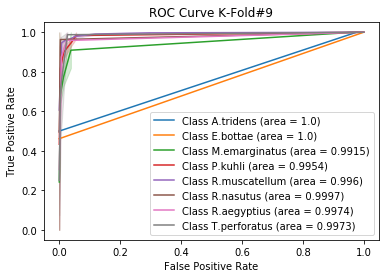

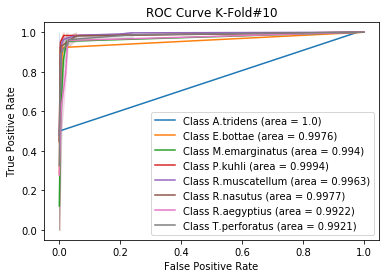

In [37]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [38]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9938684503901895
Std  0.01839464882943145
Sp:  E.bottae
AUC Mean  0.9991709976626005
Std  0.0011305653621531005
Sp:  M.emarginatus
AUC Mean  0.9914415484385266
Std  0.00846220187474548
Sp:  P.kuhli
AUC Mean  0.9984474794731091
Std  0.0017124852439792716
Sp:  R.muscatellum
AUC Mean  0.9983810966931401
Std  0.0013346921113269847
Sp:  R.nasutus
AUC Mean  0.9971125363523015
Std  0.0035471251869253124
Sp:  R.aegyptius
AUC Mean  0.997213301454144
Std  0.002440992030772277
Sp:  T.perforatus
AUC Mean  0.9963486896779996
Std  0.0031516766877164202


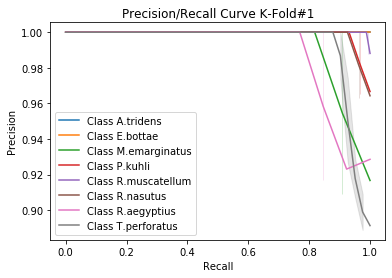

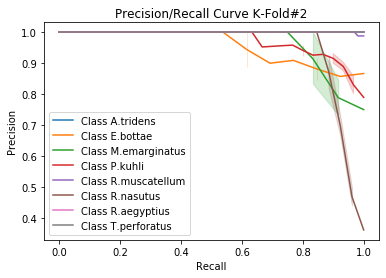

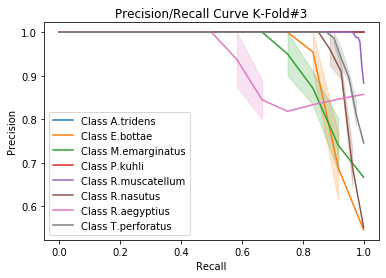

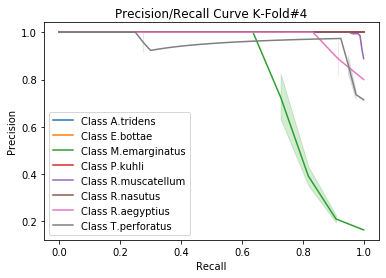

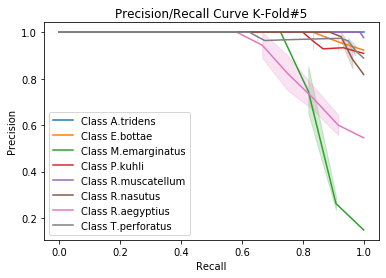

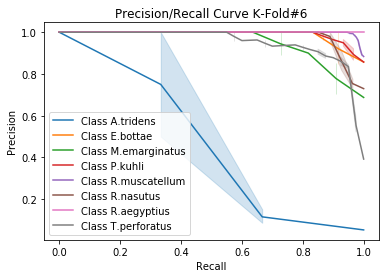

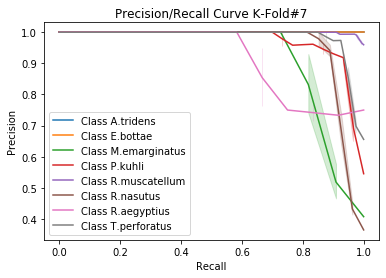

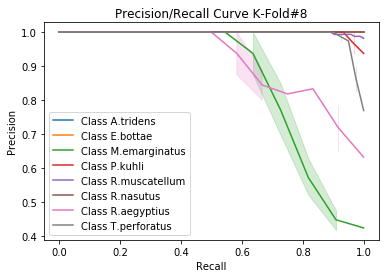

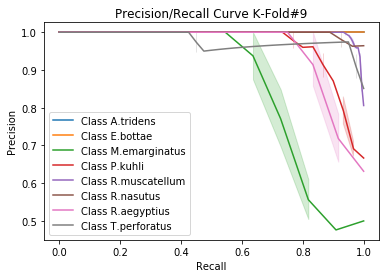

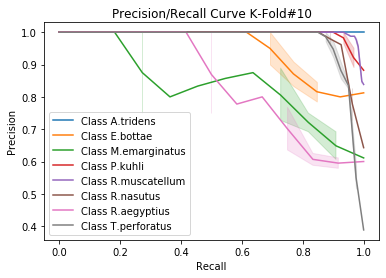

In [39]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   1   0   0]
 [  0   0   9   0   0   0   1   1]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 165   0   0   1]
 [  0   0   0   0   0  27   0   0]
 [  0   0   0   0   1   0  10   2]
 [  0   0   0   1   1   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   1   1   0   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   2  27   1   0   0   0]
 [  0   0   0   0 164   1   1   0]
 [  0   1   0   2   0  23   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   0  29   0   1   0   0]
 [  0   0   2   0 160   0   1   3]
 [  0   1   1   0   0  24   0   1]
 [  0   0   0   0   0   0  12   0]
 [  0   0   2   0   0   0   0  39]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

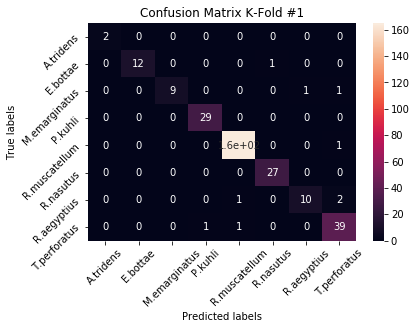

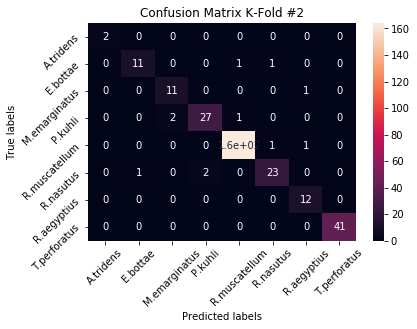

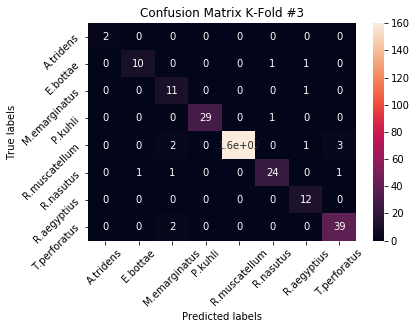

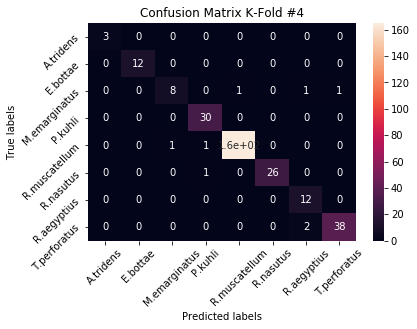

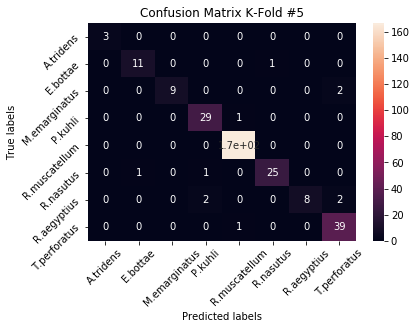

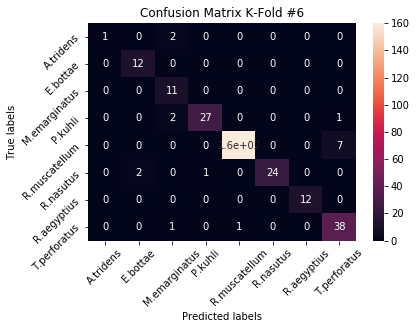

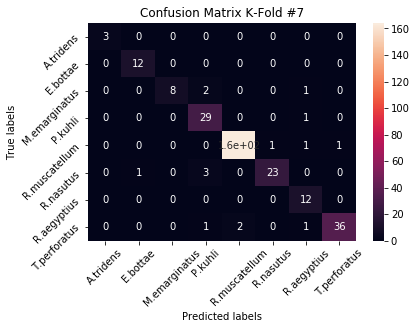

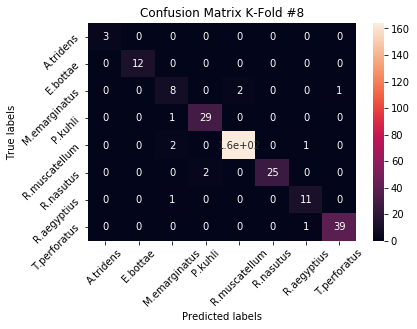

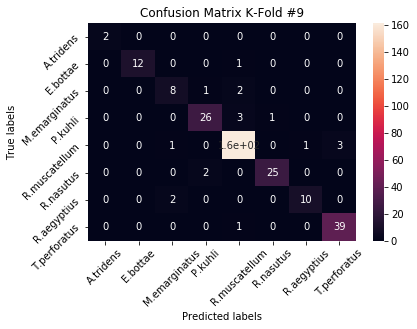

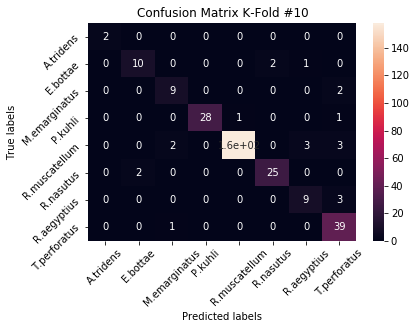

In [40]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  23    0    2    0    0    0    0    0]
 [   0  114    0    0    2    6    2    0]
 [   0    0   92    3    5    0    5    7]
 [   0    0    5  283    6    2    1    2]
 [   0    0    8    1 1628    2    8   18]
 [   0    8    1   12    0  247    0    1]
 [   0    0    3    2    1    0  108    7]
 [   0    0    4    2    6    0    4  387]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 162   0   0   1]
 [  0   0   0   1   0  24   0   0]
 [  0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0  38]]


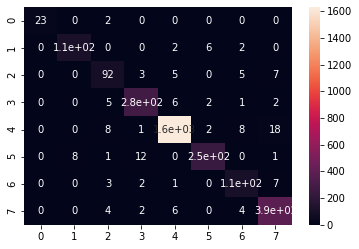

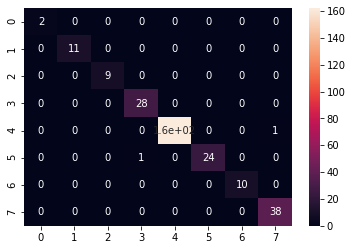

In [41]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.92 0.   0.08 0.   0.   0.   0.   0.  ]
 [0.   0.92 0.   0.   0.02 0.05 0.02 0.  ]
 [0.   0.   0.82 0.03 0.04 0.   0.04 0.06]
 [0.   0.   0.02 0.95 0.02 0.01 0.   0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.03 0.   0.04 0.   0.92 0.   0.  ]
 [0.   0.   0.02 0.02 0.01 0.   0.89 0.06]
 [0.   0.   0.01 0.   0.01 0.   0.01 0.96]]


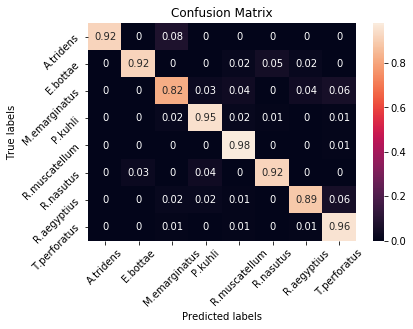

In [42]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V3 !!!!! K-Fold Training and Evaluation</h2>

In [43]:
folder = "models"
mode_version = "stft_RO_v3"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/stft_RO_v3


In [44]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=152,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=152,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=184,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=56,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
   


In [45]:
model = build_current_model()
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 56, 85, 152)       11552     
_________________________________________________________________
batch_normalization_88 (Batc (None, 56, 85, 152)       608       
_________________________________________________________________
activation_88 (Activation)   (None, 56, 85, 152)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 43, 152)       0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 43, 152)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 14, 22, 152)       577

In [46]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 20s - loss: 1.7825 - acc: 0.3074 - val_loss: 1.5529 - val_acc: 0.4026
Epoch 2/100
9592/9592 - 17s - loss: 1.2822 - acc: 0.5129 - val_loss: 1.4946 - val_acc: 0.4099
Epoch 3/100
9592/9592 - 18s - loss: 1.0094 - acc: 0.6309 - val_loss: 1.3264 - val_acc: 0.4191
Epoch 4/100
9592/9592 - 18s - loss: 0.7655 - acc: 0.7347 - val_loss: 0.7895 - val_acc: 0.7059
Epoch 5/100
9592/9592 - 18s - loss: 0.5942 - acc: 0.8008 - val_loss: 0.8603 - val_acc: 0.6

Epoch 7/100
9592/9592 - 19s - loss: 0.3696 - acc: 0.8808 - val_loss: 0.3648 - val_acc: 0.8713
Epoch 8/100
9592/9592 - 19s - loss: 0.3041 - acc: 0.9094 - val_loss: 0.5532 - val_acc: 0.8107
Epoch 9/100
9592/9592 - 18s - loss: 0.2600 - acc: 0.9221 - val_loss: 0.3367 - val_acc: 0.8824
Epoch 10/100
9592/9592 - 19s - loss: 0.2305 - acc: 0.9333 - val_loss: 0.6471 - val_acc: 0.7610
Epoch 11/100
9592/9592 - 19s - loss: 0.1970 - acc: 0.9437 - val_loss: 1.1642 - val_acc: 0.6654
Epoch 12/100
9592/9592 - 18s - loss: 0.1750 - acc: 0.9480 - val_loss: 0.2759 - val_acc: 0.9173
Epoch 13/100
9592/9592 - 19s - loss: 0.1490 - acc: 0.9563 - val_loss: 0.2834 - val_acc: 0.9099
Epoch 14/100
9592/9592 - 19s - loss: 0.1343 - acc: 0.9592 - val_loss: 1.1675 - val_acc: 0.6912
Epoch 15/100
9592/9592 - 19s - loss: 0.1352 - acc: 0.9623 - val_loss: 0.2648 - val_acc: 0.9191
Epoch 16/100
9592/9592 - 19s - loss: 0.1239 - acc: 0.9661 - val_loss: 0.1884 - val_acc: 0.9375
Epoch 17/100
9592/9592 - 19s - loss: 0.0975 - acc: 0.

Epoch 38/100
9592/9592 - 20s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1550 - val_acc: 0.9577
Epoch 39/100
9592/9592 - 20s - loss: 0.0268 - acc: 0.9926 - val_loss: 0.2499 - val_acc: 0.9375
Epoch 40/100
9592/9592 - 20s - loss: 0.0376 - acc: 0.9895 - val_loss: 0.1893 - val_acc: 0.9632
Epoch 41/100
9592/9592 - 19s - loss: 0.0437 - acc: 0.9888 - val_loss: 0.1736 - val_acc: 0.9596
Epoch 42/100
9592/9592 - 20s - loss: 0.0267 - acc: 0.9921 - val_loss: 0.2246 - val_acc: 0.9559
Epoch 43/100
9592/9592 - 20s - loss: 0.0470 - acc: 0.9879 - val_loss: 0.3158 - val_acc: 0.9136
Epoch 44/100
9592/9592 - 20s - loss: 0.0395 - acc: 0.9898 - val_loss: 0.2475 - val_acc: 0.9320
Epoch 45/100
9592/9592 - 20s - loss: 0.0301 - acc: 0.9911 - val_loss: 0.2124 - val_acc: 0.9559
Epoch 46/100
9592/9592 - 20s - loss: 0.0299 - acc: 0.9918 - val_loss: 0.1862 - val_acc: 0.9669
Epoch 47/100
9592/9592 - 19s - loss: 0.0474 - acc: 0.9871 - val_loss: 0.1963 - val_acc: 0.9540
Epoch 48/100
9592/9592 - 20s - loss: 0.0351 - acc:

Epoch 38/100
Restoring model weights from the end of the best epoch.
9584/9584 - 23s - loss: 0.0336 - acc: 0.9904 - val_loss: 0.2852 - val_acc: 0.9393
Epoch 00038: early stopping
models/stft_RO_v3_iter_6.model
Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('R.nasutus', 193), ('M.emarginatus', 81), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.tridens', 1198)]
After OverSampling
X_train: shape=  (9584, 112, 170, 3)
Y_train: shape=  (9584, 8)
Train on 9584 samples, validate on 544 samples
Epoch 1/100
9584/9584 - 21s - loss: 1.7937 - acc: 0.3083 - val_loss: 1.9948 - val_acc: 0.2592
Epoch 2/100
9584/9584 - 18s - loss: 1.3223 - acc: 0.4996 - val_loss: 2.1278 - val_acc: 0.1710
Epoch 3/100
9584/9584 - 18s - loss: 0.9435 - acc: 0.6578 - val_loss:

Epoch 29/100
9584/9584 - 18s - loss: 0.0750 - acc: 0.9794 - val_loss: 0.1445 - val_acc: 0.9559
Epoch 30/100
9584/9584 - 18s - loss: 0.0593 - acc: 0.9833 - val_loss: 0.1459 - val_acc: 0.9669
Epoch 31/100
9584/9584 - 18s - loss: 0.0467 - acc: 0.9877 - val_loss: 0.2097 - val_acc: 0.9467
Epoch 32/100
9584/9584 - 17s - loss: 0.0570 - acc: 0.9842 - val_loss: 0.4798 - val_acc: 0.8658
Epoch 33/100
9584/9584 - 18s - loss: 0.0602 - acc: 0.9834 - val_loss: 0.1979 - val_acc: 0.9504
Epoch 34/100
9584/9584 - 18s - loss: 0.0498 - acc: 0.9862 - val_loss: 0.1679 - val_acc: 0.9596
Epoch 35/100
9584/9584 - 17s - loss: 0.0648 - acc: 0.9829 - val_loss: 0.1874 - val_acc: 0.9485
Epoch 36/100
9584/9584 - 18s - loss: 0.0352 - acc: 0.9901 - val_loss: 0.2524 - val_acc: 0.9301
Epoch 37/100
9584/9584 - 18s - loss: 0.0490 - acc: 0.9864 - val_loss: 0.2306 - val_acc: 0.9485
Epoch 38/100
9584/9584 - 17s - loss: 0.0507 - acc: 0.9854 - val_loss: 0.3916 - val_acc: 0.9026
Epoch 39/100
9584/9584 - 18s - loss: 0.0369 - acc:

Epoch 22/100
9592/9592 - 19s - loss: 0.0657 - acc: 0.9814 - val_loss: 0.2258 - val_acc: 0.9522
Epoch 23/100
9592/9592 - 19s - loss: 0.0666 - acc: 0.9819 - val_loss: 0.3603 - val_acc: 0.8915
Epoch 24/100
9592/9592 - 20s - loss: 0.0629 - acc: 0.9821 - val_loss: 0.3589 - val_acc: 0.8934
Epoch 25/100
9592/9592 - 19s - loss: 0.0622 - acc: 0.9821 - val_loss: 0.5092 - val_acc: 0.8401
Epoch 26/100
9592/9592 - 19s - loss: 0.0743 - acc: 0.9812 - val_loss: 0.1964 - val_acc: 0.9301
Epoch 27/100
9592/9592 - 19s - loss: 0.0459 - acc: 0.9874 - val_loss: 0.4764 - val_acc: 0.8713
Epoch 28/100
9592/9592 - 20s - loss: 0.0587 - acc: 0.9854 - val_loss: 0.3187 - val_acc: 0.9062
Epoch 29/100
9592/9592 - 19s - loss: 0.0515 - acc: 0.9853 - val_loss: 0.2810 - val_acc: 0.9449
Epoch 30/100
9592/9592 - 19s - loss: 0.0457 - acc: 0.9863 - val_loss: 0.2787 - val_acc: 0.9136
Epoch 31/100
9592/9592 - 19s - loss: 0.0581 - acc: 0.9843 - val_loss: 0.4151 - val_acc: 0.8989
Epoch 32/100
9592/9592 - 20s - loss: 0.0466 - acc:

In [47]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/stft_RO_v3_iter_1.model
File Name Loaded:  models/stft_RO_v3_iter_2.model
File Name Loaded:  models/stft_RO_v3_iter_3.model
File Name Loaded:  models/stft_RO_v3_iter_4.model
File Name Loaded:  models/stft_RO_v3_iter_5.model
File Name Loaded:  models/stft_RO_v3_iter_6.model
File Name Loaded:  models/stft_RO_v3_iter_7.model
File Name Loaded:  models/stft_RO_v3_iter_8.model
File Name Loaded:  models/stft_RO_v3_iter_9.model
File Name Loaded:  models/stft_RO_v3_iter_10.model


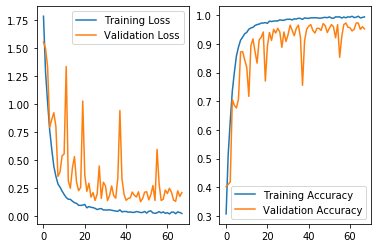

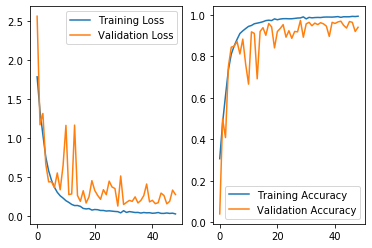

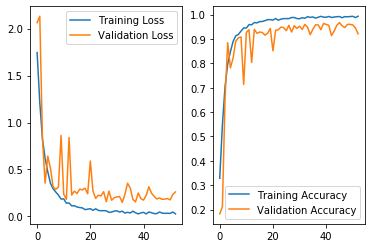

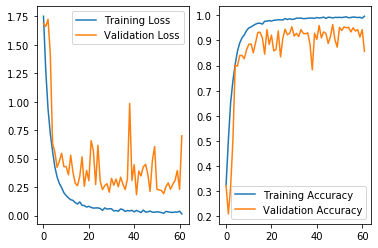

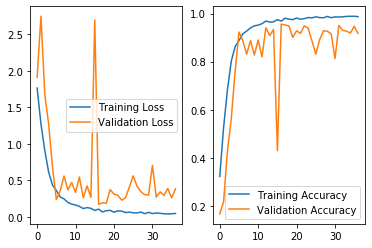

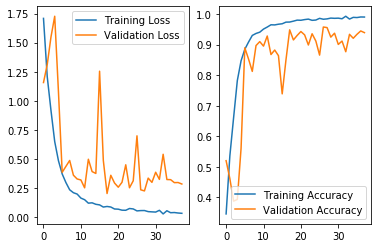

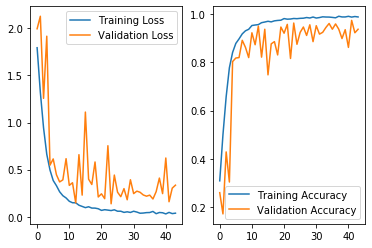

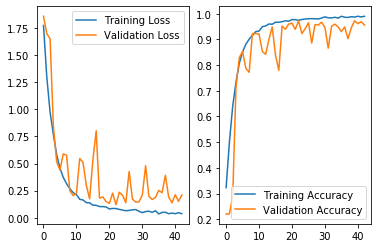

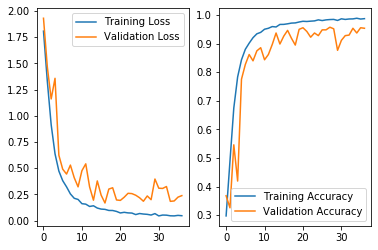

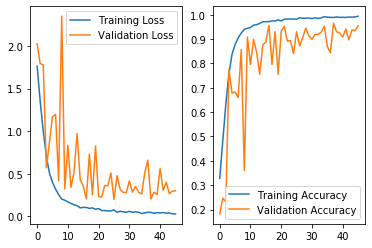

In [48]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [49]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.93816184 0.84128597 0.91527798 0.98567282 0.94919617
 0.8227381  0.9352861 ]
precision sdev by class [0.         0.06609651 0.16587173 0.05702467 0.01667996 0.06456186
 0.11060824 0.03293708]
macro precision mean 0.9234523713951269
macro precision sdev 0.03088203423500037
recall mean [0.93333333 0.92884615 0.82121212 0.95655172 0.97415771 0.91068376
 0.89166667 0.9427439 ]
recall sdev [0.2        0.07283191 0.12103206 0.04226948 0.01767422 0.03804272
 0.08374896 0.06985072]
macro recall mean 0.9198994213747523
macro recall sdev 0.03316978004042177
f1 mean [0.95       0.93156076 0.82120093 0.93504864 0.979733   0.92844443
 0.84822738 0.93702064]
f1 sdev [0.15       0.05648451 0.11176349 0.0465696  0.01250913 0.04230608
 0.05906205 0.03839293]
macro f1 mean 0.9164044710526346
macro f1 sdev 0.03054827825982441
accuracy mean 0.9512694990209235
accuracy sdev 0.018600106281468656


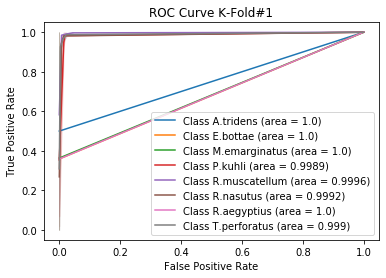

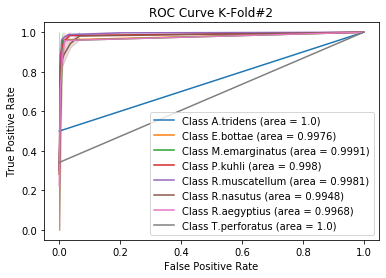

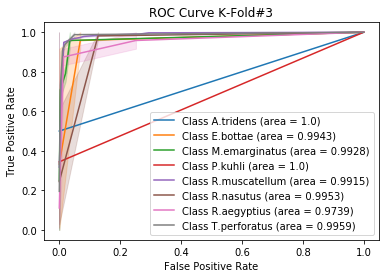

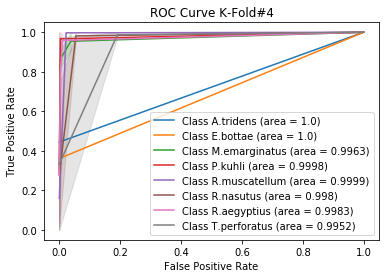

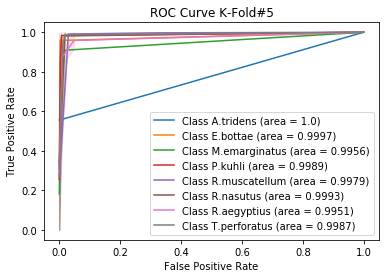

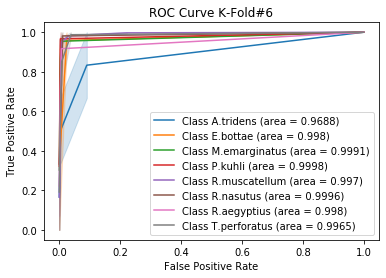

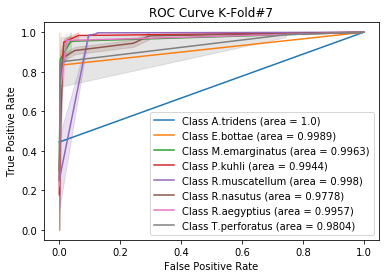

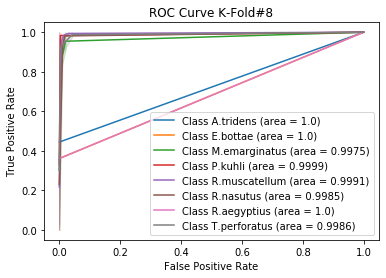

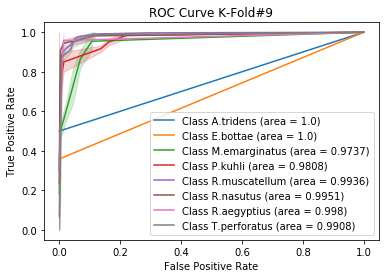

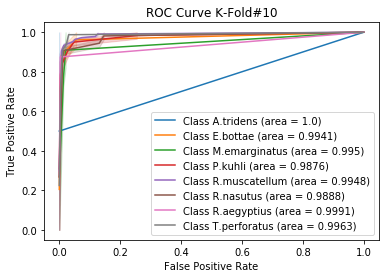

In [50]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [51]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9968784838350055
Std  0.00936454849498326
Sp:  E.bottae
AUC Mean  0.9982533000977994
Std  0.002196279893252755
Sp:  M.emarginatus
AUC Mean  0.9945298344267417
Std  0.007252803128828131
Sp:  P.kuhli
AUC Mean  0.9957938164156401
Std  0.006195709665621178
Sp:  R.muscatellum
AUC Mean  0.9969384349263517
Std  0.0026348622267385155
Sp:  R.nasutus
AUC Mean  0.9946435263374329
Std  0.0064250376759568024
Sp:  R.aegyptius
AUC Mean  0.9954875114345942
Std  0.007378634138906306
Sp:  T.perforatus
AUC Mean  0.9951299487955396
Std  0.005486303795008309


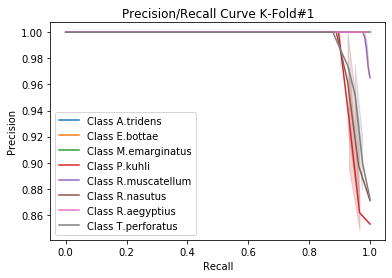

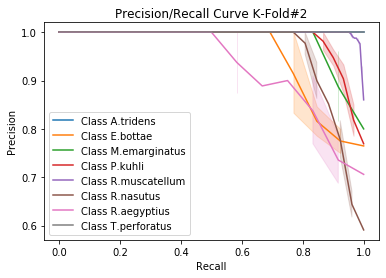

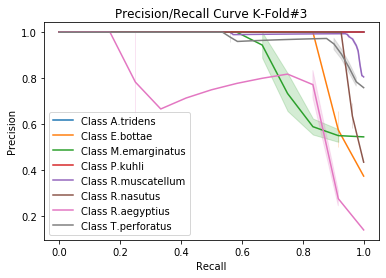

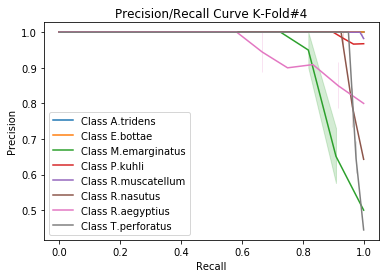

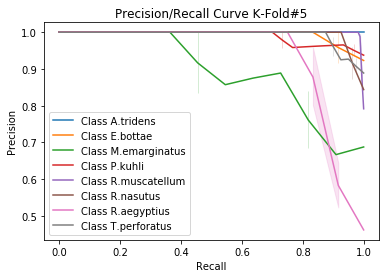

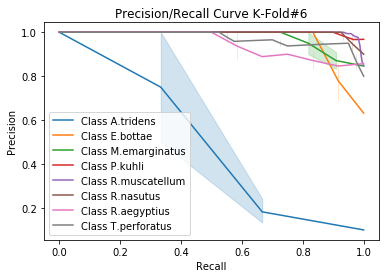

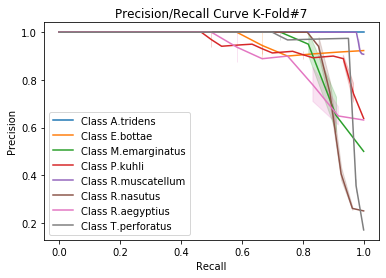

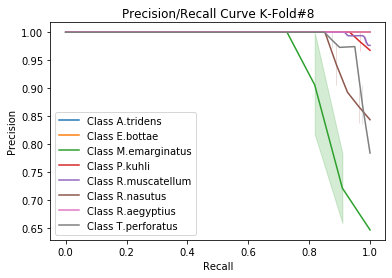

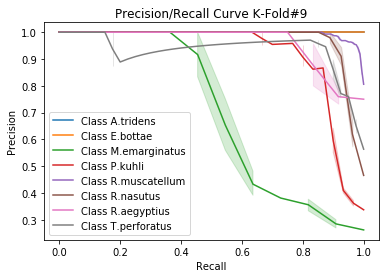

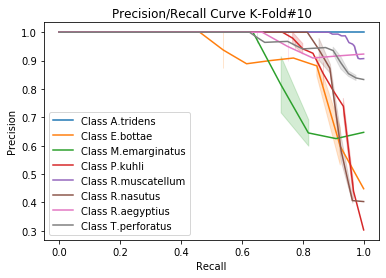

In [52]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   1   0   0]
 [  0   0   9   2   0   0   0   0]
 [  0   0   0  28   0   0   1   0]
 [  0   0   0   0 163   0   0   3]
 [  0   0   0   2   0  25   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   0   0   1  40]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   1   2   0   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   0  28   0   2   0   0]
 [  0   0   0   0 163   1   2   0]
 [  0   1   0   2   0  23   0   0]
 [  0   0   0   0   1   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   1   0]
 [  0   0   9   0   2   0   1   0]
 [  0   0   0  29   1   0   0   0]
 [  0   0   1   0 161   0   1   3]
 [  0   0   0   0   0  26   0   1]
 [  0   0   0   0   2   0  10   0]
 [  0   0   0   0   2   0   1  38]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

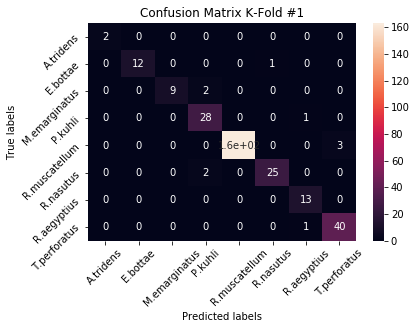

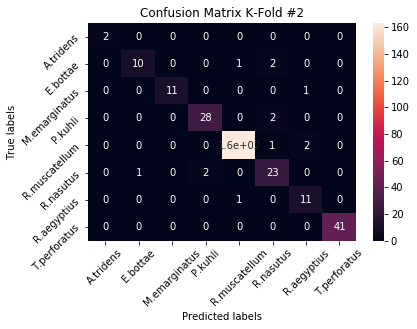

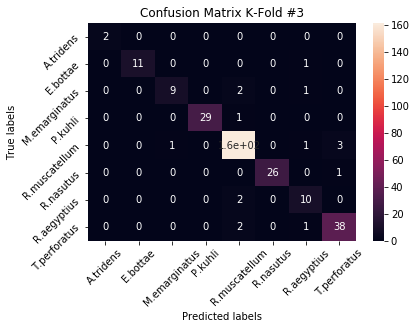

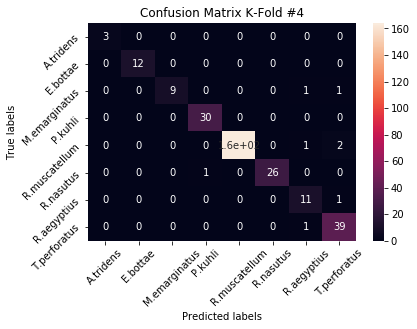

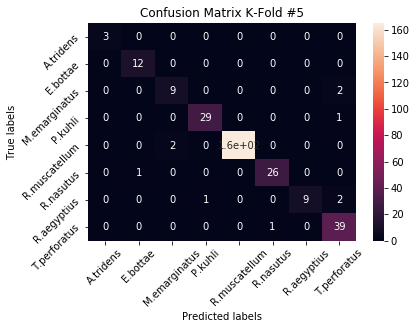

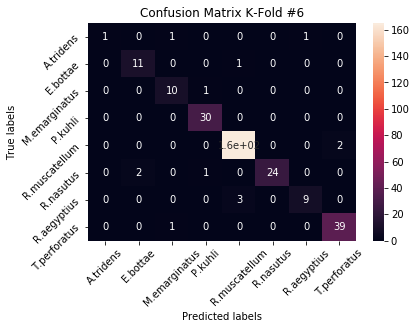

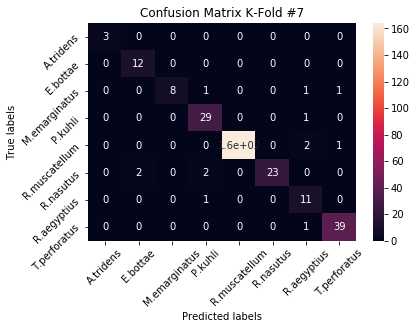

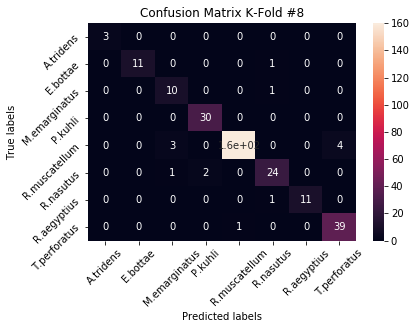

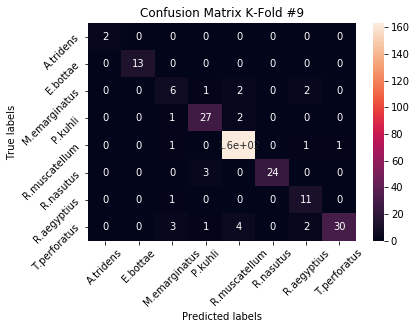

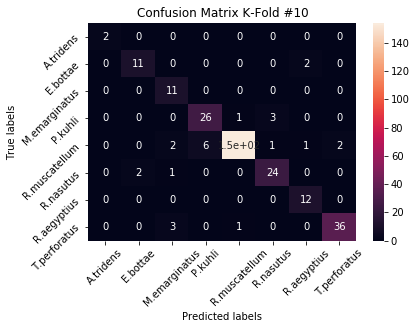

In [53]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  23    0    1    0    0    0    1    0]
 [   0  115    0    0    2    4    3    0]
 [   0    0   92    5    4    1    6    4]
 [   0    0    1  286    4    5    2    1]
 [   0    0    9    6 1622    2    8   18]
 [   0    8    2   13    0  245    0    1]
 [   0    0    1    2    6    1  108    3]
 [   0    0    7    1    8    1    6  380]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 162   0   0   1]
 [  0   0   0   1   0  24   0   0]
 [  0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0  38]]


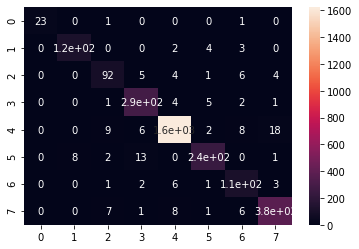

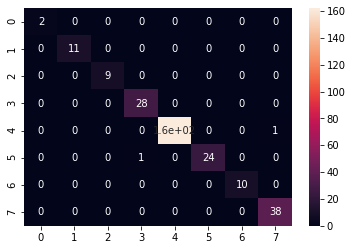

In [54]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.92 0.   0.04 0.   0.   0.   0.04 0.  ]
 [0.   0.93 0.   0.   0.02 0.03 0.02 0.  ]
 [0.   0.   0.82 0.04 0.04 0.01 0.05 0.04]
 [0.   0.   0.   0.96 0.01 0.02 0.01 0.  ]
 [0.   0.   0.01 0.   0.97 0.   0.   0.01]
 [0.   0.03 0.01 0.05 0.   0.91 0.   0.  ]
 [0.   0.   0.01 0.02 0.05 0.01 0.89 0.02]
 [0.   0.   0.02 0.   0.02 0.   0.01 0.94]]


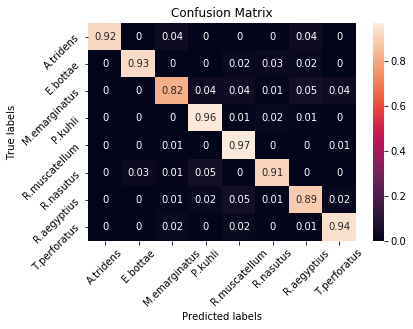

In [55]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V4 !!!!! K-Fold Training and Evaluation</h2>

In [56]:
folder = "models"
mode_version = "stft_RO_v4"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/stft_RO_v4


In [57]:
 def build_current_model():
    inp = Input(shape=(112,170,3))
    
    lay = Convolution2D(filters=240,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=80,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(128)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.4)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [58]:
model = build_current_model()
model.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 56, 85, 240)       18240     
_________________________________________________________________
batch_normalization_165 (Bat (None, 56, 85, 240)       960       
_________________________________________________________________
activation_165 (Activation)  (None, 56, 85, 240)       0         
_________________________________________________________________
average_pooling2d_99 (Averag (None, 28, 43, 240)       0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 28, 43, 240)       0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 14, 22, 80)        480

In [59]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 22s - loss: 1.5699 - acc: 0.4101 - val_loss: 1.7056 - val_acc: 0.2188
Epoch 2/100
9592/9592 - 18s - loss: 0.9344 - acc: 0.6496 - val_loss: 0.8471 - val_acc: 0.6691
Epoch 3/100
9592/9592 - 18s - loss: 0.6222 - acc: 0.7677 - val_loss: 1.7120 - val_acc: 0.4338
Epoch 4/100
9592/9592 - 18s - loss: 0.4535 - acc: 0.8421 - val_loss: 0.5161 - val_acc: 0.8364
Epoch 5/100
9592/9592 - 18s - loss: 0.3555 - acc: 0.8764 - val_loss: 0.4375 - val_acc: 0.8

Epoch 45/100
9592/9592 - 18s - loss: 0.0689 - acc: 0.9788 - val_loss: 0.3794 - val_acc: 0.8971
Epoch 46/100
9592/9592 - 17s - loss: 0.0743 - acc: 0.9766 - val_loss: 0.7266 - val_acc: 0.8217
Epoch 47/100
Restoring model weights from the end of the best epoch.
9592/9592 - 21s - loss: 0.0611 - acc: 0.9783 - val_loss: 0.3251 - val_acc: 0.9173
Epoch 00047: early stopping
models/stft_RO_v4_iter_2.model
Original training set shape [('T.perforatus', 289), ('R.muscatellum', 1199), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('M.emarginatus', 80), ('R.nasutus', 194), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('E.bottae', 1199), ('R.aegyptius', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.nasutus', 1199), ('A.tridens', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 23s - loss: 1.5097 - acc: 0.4372 - val_los

Epoch 41/100
9584/9584 - 18s - loss: 0.0546 - acc: 0.9817 - val_loss: 0.9208 - val_acc: 0.7960
Epoch 42/100
9584/9584 - 18s - loss: 0.0660 - acc: 0.9789 - val_loss: 0.4492 - val_acc: 0.8989
Epoch 43/100
9584/9584 - 18s - loss: 0.0537 - acc: 0.9847 - val_loss: 0.8751 - val_acc: 0.8511
Epoch 44/100
9584/9584 - 18s - loss: 0.0665 - acc: 0.9784 - val_loss: 1.6950 - val_acc: 0.7335
Epoch 45/100
9584/9584 - 18s - loss: 0.0609 - acc: 0.9799 - val_loss: 0.4391 - val_acc: 0.8952
Epoch 46/100
9584/9584 - 18s - loss: 0.0616 - acc: 0.9799 - val_loss: 0.4027 - val_acc: 0.8879
Epoch 47/100
9584/9584 - 18s - loss: 0.0562 - acc: 0.9814 - val_loss: 1.5882 - val_acc: 0.7169
Epoch 48/100
9584/9584 - 18s - loss: 0.0593 - acc: 0.9808 - val_loss: 0.5376 - val_acc: 0.8566
Epoch 49/100
9584/9584 - 17s - loss: 0.0538 - acc: 0.9826 - val_loss: 0.7932 - val_acc: 0.8401
Epoch 50/100
9584/9584 - 18s - loss: 0.0491 - acc: 0.9842 - val_loss: 0.4835 - val_acc: 0.8768
Epoch 51/100
9584/9584 - 18s - loss: 0.0604 - acc:

Epoch 8/100
9584/9584 - 18s - loss: 0.2259 - acc: 0.9233 - val_loss: 0.8130 - val_acc: 0.7426
Epoch 9/100
9584/9584 - 18s - loss: 0.2132 - acc: 0.9298 - val_loss: 0.9223 - val_acc: 0.7610
Epoch 10/100
9584/9584 - 18s - loss: 0.2018 - acc: 0.9340 - val_loss: 0.8770 - val_acc: 0.7721
Epoch 11/100
9584/9584 - 18s - loss: 0.1712 - acc: 0.9419 - val_loss: 0.6364 - val_acc: 0.8180
Epoch 12/100
9584/9584 - 17s - loss: 0.1781 - acc: 0.9413 - val_loss: 0.7099 - val_acc: 0.8070
Epoch 13/100
9584/9584 - 17s - loss: 0.1457 - acc: 0.9533 - val_loss: 0.5727 - val_acc: 0.7886
Epoch 14/100
9584/9584 - 17s - loss: 0.1480 - acc: 0.9520 - val_loss: 0.3915 - val_acc: 0.8952
Epoch 15/100
9584/9584 - 18s - loss: 0.1401 - acc: 0.9535 - val_loss: 2.1654 - val_acc: 0.6434
Epoch 16/100
9584/9584 - 18s - loss: 0.1363 - acc: 0.9552 - val_loss: 0.7245 - val_acc: 0.7886
Epoch 17/100
9584/9584 - 18s - loss: 0.1293 - acc: 0.9586 - val_loss: 0.4769 - val_acc: 0.8327
Epoch 18/100
9584/9584 - 18s - loss: 0.1079 - acc: 0

Epoch 23/100
9584/9584 - 17s - loss: 0.0952 - acc: 0.9688 - val_loss: 0.4174 - val_acc: 0.8879
Epoch 24/100
9584/9584 - 18s - loss: 0.1073 - acc: 0.9661 - val_loss: 1.5521 - val_acc: 0.7040
Epoch 25/100
9584/9584 - 18s - loss: 0.0992 - acc: 0.9683 - val_loss: 1.1549 - val_acc: 0.7923
Epoch 26/100
9584/9584 - 18s - loss: 0.0939 - acc: 0.9693 - val_loss: 0.8518 - val_acc: 0.7996
Epoch 27/100
9584/9584 - 18s - loss: 0.0897 - acc: 0.9712 - val_loss: 0.3972 - val_acc: 0.8915
Epoch 28/100
9584/9584 - 18s - loss: 0.0867 - acc: 0.9726 - val_loss: 0.4182 - val_acc: 0.8787
Epoch 29/100
9584/9584 - 18s - loss: 0.0950 - acc: 0.9703 - val_loss: 0.9287 - val_acc: 0.7610
Epoch 30/100
9584/9584 - 17s - loss: 0.0819 - acc: 0.9739 - val_loss: 0.7303 - val_acc: 0.7261
Epoch 31/100
9584/9584 - 18s - loss: 0.0766 - acc: 0.9777 - val_loss: 0.4457 - val_acc: 0.8750
Epoch 32/100
9584/9584 - 18s - loss: 0.0839 - acc: 0.9739 - val_loss: 0.4917 - val_acc: 0.8272
Epoch 33/100
9584/9584 - 18s - loss: 0.0898 - acc:

X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 22s - loss: 1.5979 - acc: 0.4025 - val_loss: 1.1031 - val_acc: 0.5717
Epoch 2/100
9592/9592 - 17s - loss: 0.9880 - acc: 0.6295 - val_loss: 0.9300 - val_acc: 0.5607
Epoch 3/100
9592/9592 - 17s - loss: 0.6939 - acc: 0.7489 - val_loss: 0.9397 - val_acc: 0.6268
Epoch 4/100
9592/9592 - 18s - loss: 0.5150 - acc: 0.8193 - val_loss: 0.4697 - val_acc: 0.8346
Epoch 5/100
9592/9592 - 17s - loss: 0.4012 - acc: 0.8596 - val_loss: 0.7459 - val_acc: 0.7555
Epoch 6/100
9592/9592 - 17s - loss: 0.3387 - acc: 0.8886 - val_loss: 0.5230 - val_acc: 0.8346
Epoch 7/100
9592/9592 - 17s - loss: 0.2839 - acc: 0.9067 - val_loss: 0.7246 - val_acc: 0.7684
Epoch 8/100
9592/9592 - 18s - loss: 0.2430 - acc: 0.9188 - val_loss: 0.3380 - val_acc: 0.8989
Epoch 9/100
9592/9592 - 17s - loss: 0.2112 - acc: 0.9304 - val_loss: 0.3797 - val_acc: 0.8548
Epoch 10/100
9592/9592 - 18s - loss: 0.1873

Epoch 34/100
9592/9592 - 17s - loss: 0.0811 - acc: 0.9739 - val_loss: 0.3918 - val_acc: 0.8934
Epoch 35/100
9592/9592 - 17s - loss: 0.0651 - acc: 0.9778 - val_loss: 0.9515 - val_acc: 0.7831
Epoch 36/100
9592/9592 - 18s - loss: 0.0659 - acc: 0.9781 - val_loss: 0.5006 - val_acc: 0.8805
Epoch 37/100
9592/9592 - 17s - loss: 0.0715 - acc: 0.9786 - val_loss: 0.2857 - val_acc: 0.9301
Epoch 38/100
9592/9592 - 18s - loss: 0.0735 - acc: 0.9751 - val_loss: 0.3290 - val_acc: 0.9154
Epoch 39/100
9592/9592 - 18s - loss: 0.0660 - acc: 0.9781 - val_loss: 0.5099 - val_acc: 0.8989
Epoch 40/100
9592/9592 - 18s - loss: 0.0592 - acc: 0.9807 - val_loss: 0.8537 - val_acc: 0.7886
Epoch 41/100
9592/9592 - 17s - loss: 0.0715 - acc: 0.9762 - val_loss: 0.5290 - val_acc: 0.8603
Epoch 42/100
9592/9592 - 17s - loss: 0.0598 - acc: 0.9808 - val_loss: 5.7039 - val_acc: 0.6452
Epoch 43/100
9592/9592 - 17s - loss: 0.0724 - acc: 0.9782 - val_loss: 0.4415 - val_acc: 0.8934
Epoch 44/100
9592/9592 - 17s - loss: 0.0641 - acc:

In [60]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/stft_RO_v4_iter_1.model
File Name Loaded:  models/stft_RO_v4_iter_2.model
File Name Loaded:  models/stft_RO_v4_iter_3.model
File Name Loaded:  models/stft_RO_v4_iter_4.model
File Name Loaded:  models/stft_RO_v4_iter_5.model
File Name Loaded:  models/stft_RO_v4_iter_6.model
File Name Loaded:  models/stft_RO_v4_iter_7.model
File Name Loaded:  models/stft_RO_v4_iter_8.model
File Name Loaded:  models/stft_RO_v4_iter_9.model
File Name Loaded:  models/stft_RO_v4_iter_10.model


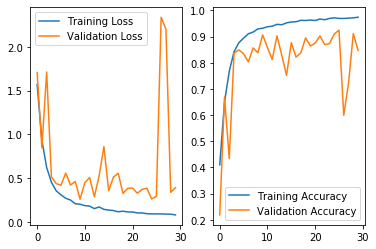

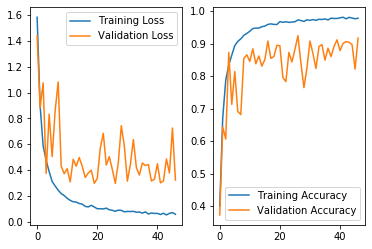

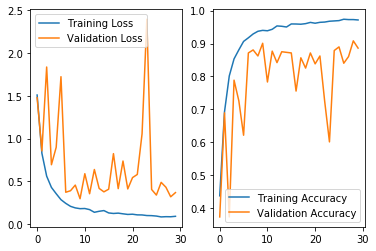

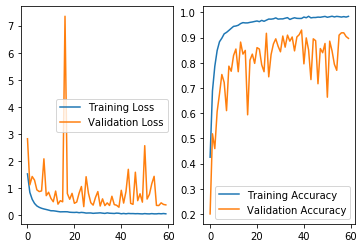

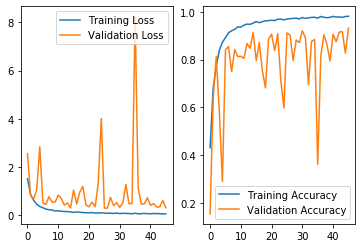

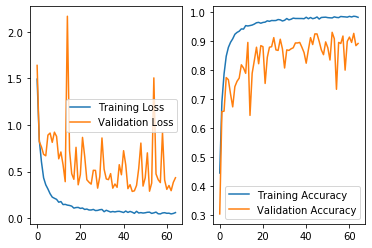

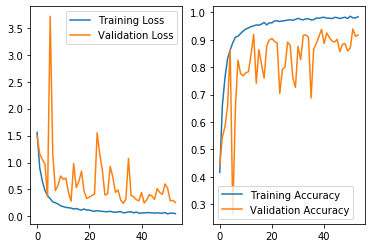

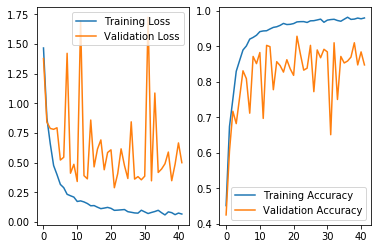

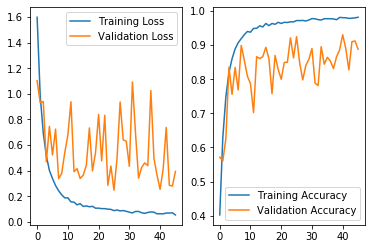

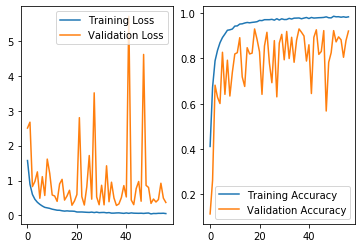

In [61]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [62]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.84010823 0.82577922 0.83643576 0.9665184  0.93565602
 0.7140803  0.86290837]
precision sdev by class [0.         0.0544865  0.15874301 0.07496099 0.02591319 0.0487916
 0.11683808 0.06205581]
macro precision mean 0.8726857873364258
macro precision sdev 0.0276308404607221
recall mean [0.83333333 0.85576923 0.6219697  0.95310345 0.9537335  0.81766382
 0.80448718 0.89353659]
recall sdev [0.25819889 0.0914782  0.12533014 0.04771098 0.01615887 0.04893323
 0.16605534 0.08272896]
macro recall mean 0.841699598590834
macro recall sdev 0.05296921391353433
f1 mean [0.88333333 0.84345181 0.69728149 0.88787048 0.95989048 0.87101016
 0.74050994 0.87629606]
f1 sdev [0.18333333 0.0453576  0.11370739 0.04049509 0.01671864 0.03095692
 0.09875936 0.062272  ]
macro f1 mean 0.844955468931877
macro f1 sdev 0.039008089460700245
accuracy mean 0.9102043959428837
accuracy sdev 0.02426641486590657


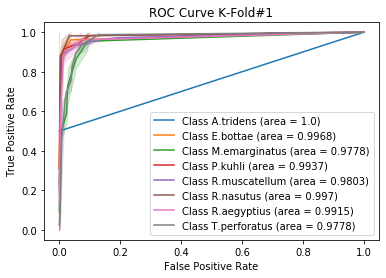

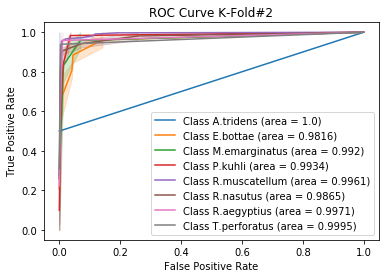

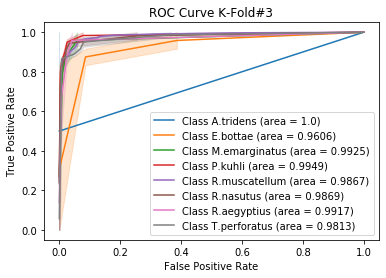

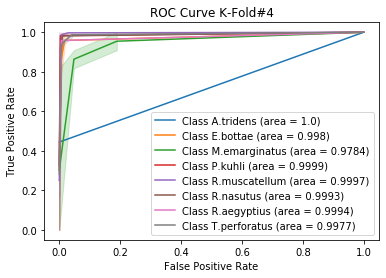

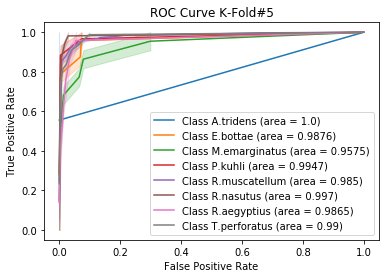

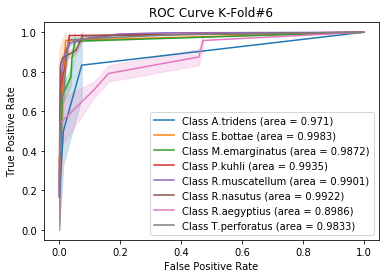

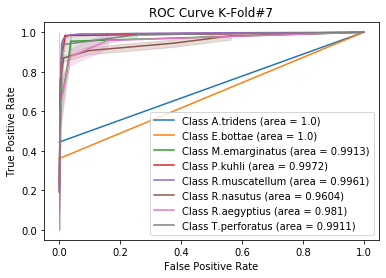

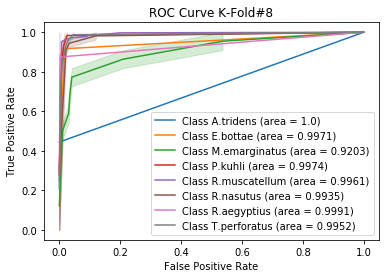

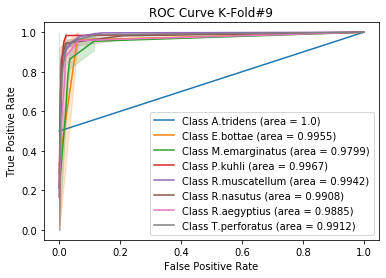

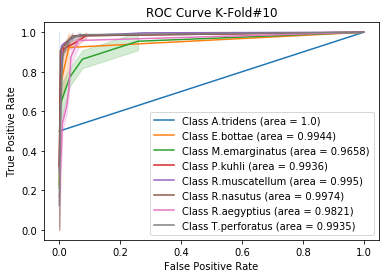

In [63]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [64]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9971014492753623
Std  0.008695652173913016
Sp:  E.bottae
AUC Mean  0.9909957338893325
Std  0.011430620080410828
Sp:  M.emarginatus
AUC Mean  0.9742809359144233
Std  0.021034161587063123
Sp:  P.kuhli
AUC Mean  0.9954923261625066
Std  0.0020846286098163062
Sp:  R.muscatellum
AUC Mean  0.9919525245909473
Std  0.005843100866276874
Sp:  R.nasutus
AUC Mean  0.990118743152542
Std  0.010755170199816878
Sp:  R.aegyptius
AUC Mean  0.9815519077033216
Std  0.028341074213152184
Sp:  T.perforatus
AUC Mean  0.9900623657559292
Std  0.006802043417842022


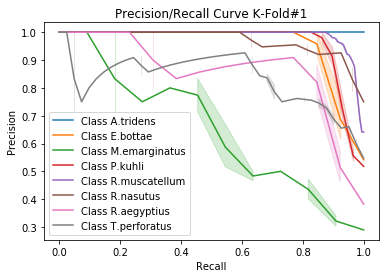

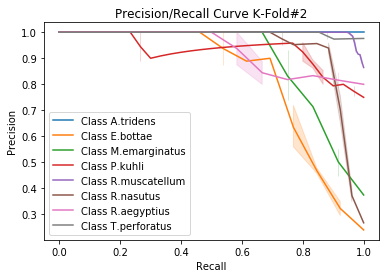

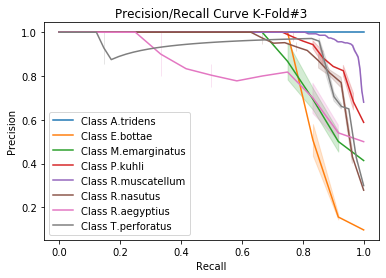

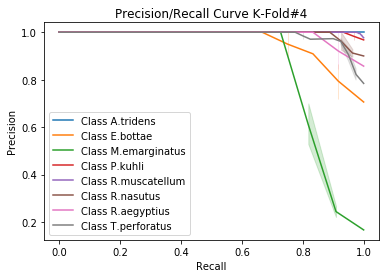

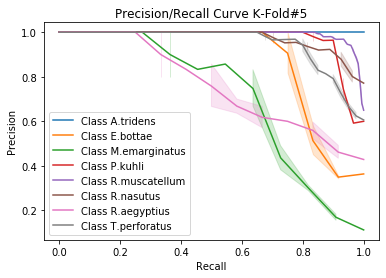

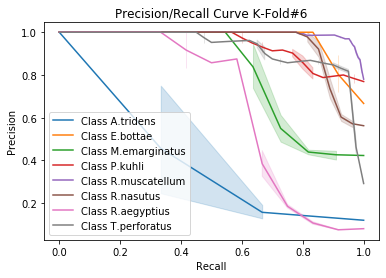

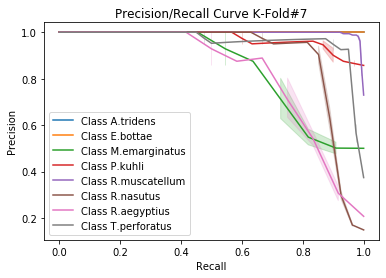

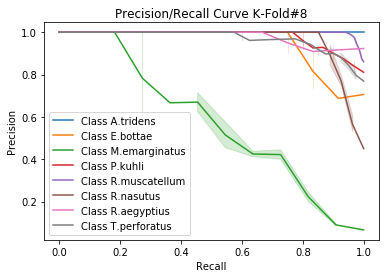

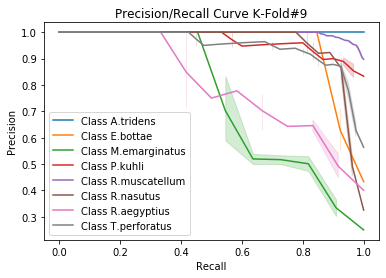

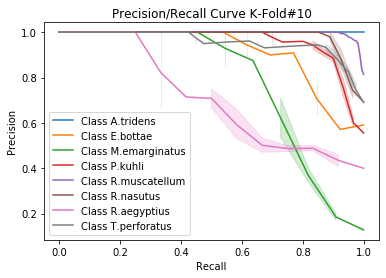

In [65]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   1   0   0   0]
 [  0   1   6   1   1   0   1   1]
 [  0   0   0  27   2   0   0   0]
 [  0   0   1   0 157   2   0   6]
 [  0   2   0   4   1  20   0   0]
 [  0   0   4   0   1   0   6   2]
 [  0   0   1   2   9   0   0  29]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   1   0   1   1   0]
 [  0   0  10   1   0   0   1   0]
 [  0   0   1  29   0   0   0   0]
 [  0   1   3   4 156   0   1   1]
 [  0   1   0   3   0  20   2   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0   9   0   1   0   2   0]
 [  0   0   0  25   0   3   0   2]
 [  0   1   0   1 156   1   1   6]
 [  0   1   0   2   1  23   0   0]
 [  0   0   0   0   2   0  10   0]
 [  0   0   0   0   4   0   1  36]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

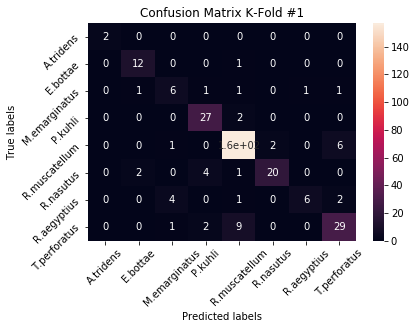

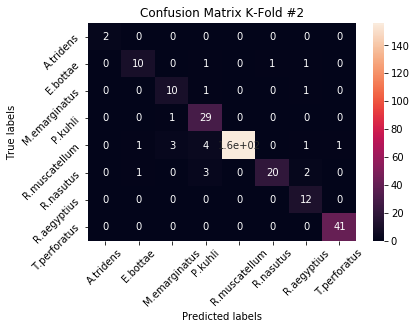

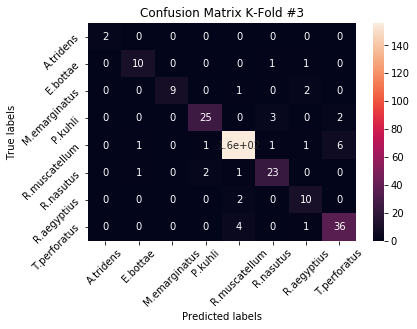

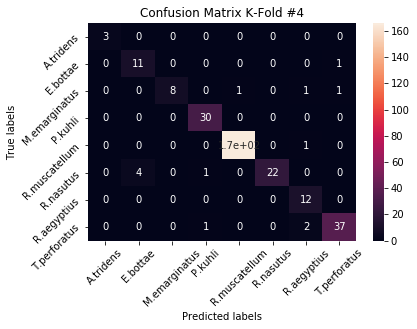

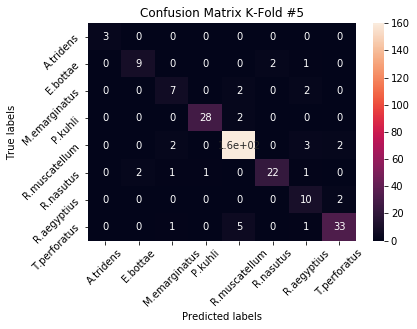

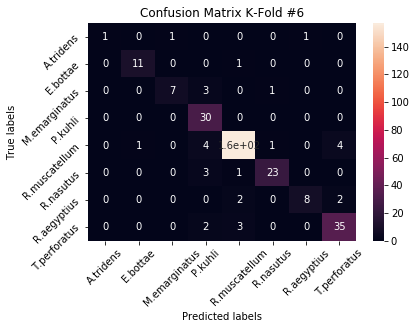

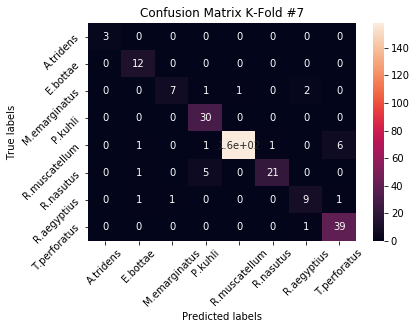

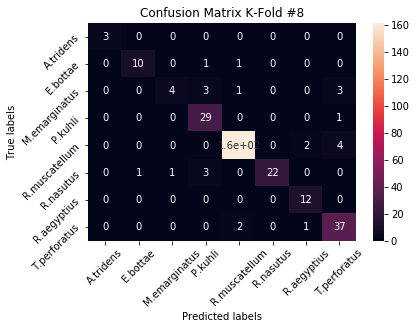

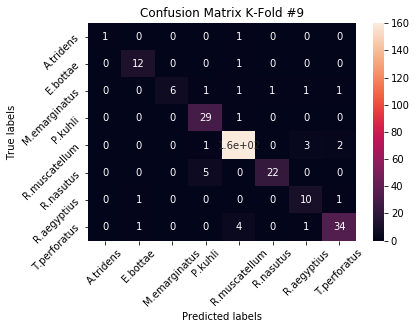

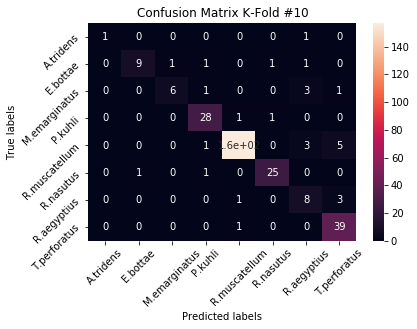

In [66]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  21    0    1    0    1    0    2    0]
 [   0  106    1    3    4    5    4    1]
 [   0    1   70   11    8    2   13    7]
 [   0    0    1  285    6    4    0    3]
 [   0    4    6   12 1588    5   14   36]
 [   0   13    2   28    3  220    3    0]
 [   0    2    5    0    6    0   97   11]
 [   0    1    2    5   28    0    7  360]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   0   0   0]
 [  0   0   7   1   0   0   1   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   1 158   0   1   3]
 [  0   1   0   2   0  22   0   0]
 [  0   0   0   0   0   0   9   1]
 [  0   0   0   0   2   0   0  36]]


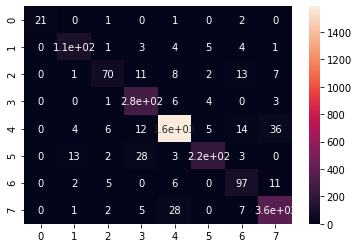

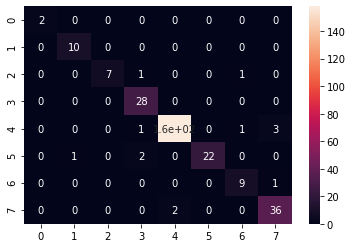

In [67]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.84 0.   0.04 0.   0.04 0.   0.08 0.  ]
 [0.   0.85 0.01 0.02 0.03 0.04 0.03 0.01]
 [0.   0.01 0.62 0.1  0.07 0.02 0.12 0.06]
 [0.   0.   0.   0.95 0.02 0.01 0.   0.01]
 [0.   0.   0.   0.01 0.95 0.   0.01 0.02]
 [0.   0.05 0.01 0.1  0.01 0.82 0.01 0.  ]
 [0.   0.02 0.04 0.   0.05 0.   0.8  0.09]
 [0.   0.   0.   0.01 0.07 0.   0.02 0.89]]


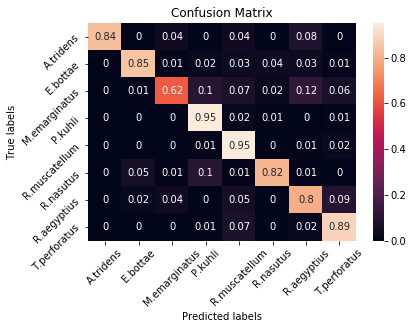

In [68]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V5 !!!!! K-Fold Training and Evaluation</h2>

In [17]:
folder = "models"
mode_version = "stft_RO_v5"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/stft_RO_v5


In [19]:
def build_current_model():
    inp = inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120 ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=96,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    return model



In [20]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 120)       480       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 120)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 96)        288096

In [ ]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 13s - loss: 1.7686 - acc: 0.3267 - val_loss: 1.7897 - val_acc: 0.1618
Epoch 2/100
9592/9592 - 12s - loss: 1.2781 - acc: 0.5140 - val_loss: 1.0703 - val_acc: 0.5037
Epoch 3/100
9592/9592 - 11s - loss: 0.9150 - acc: 0.6688 - val_loss: 1.3339 - val_acc: 0.4651
Epoch 4/100
9592/9592 - 11s - loss: 0.6787 - acc: 0.7670 - val_loss: 0.5356 - val_acc: 0.7721
Epoch 5/100
9592/9592 - 12s - loss: 0.5440 - acc: 0.8215 - val_loss: 0.3989 - val_acc: 0.8

Epoch 25/100
9592/9592 - 12s - loss: 0.1023 - acc: 0.9704 - val_loss: 0.3954 - val_acc: 0.8989
Epoch 26/100
9592/9592 - 12s - loss: 0.0987 - acc: 0.9715 - val_loss: 0.4501 - val_acc: 0.8529
Epoch 27/100
9592/9592 - 12s - loss: 0.0865 - acc: 0.9723 - val_loss: 0.1262 - val_acc: 0.9614
Epoch 28/100
9592/9592 - 12s - loss: 0.0824 - acc: 0.9751 - val_loss: 0.5209 - val_acc: 0.8860
Epoch 29/100
9592/9592 - 12s - loss: 0.0954 - acc: 0.9714 - val_loss: 0.1698 - val_acc: 0.9504
Epoch 30/100
9592/9592 - 12s - loss: 0.0800 - acc: 0.9772 - val_loss: 0.3450 - val_acc: 0.8842
Epoch 31/100
9592/9592 - 12s - loss: 0.0847 - acc: 0.9761 - val_loss: 0.1692 - val_acc: 0.9559
Epoch 32/100
9592/9592 - 12s - loss: 0.0806 - acc: 0.9762 - val_loss: 0.1736 - val_acc: 0.9504
Epoch 33/100
9592/9592 - 12s - loss: 0.0850 - acc: 0.9761 - val_loss: 0.3797 - val_acc: 0.8989
Epoch 34/100
9592/9592 - 12s - loss: 0.0690 - acc: 0.9791 - val_loss: 0.1915 - val_acc: 0.9522
Epoch 35/100
9592/9592 - 12s - loss: 0.0719 - acc:

Epoch 42/100
9592/9592 - 13s - loss: 0.0583 - acc: 0.9842 - val_loss: 0.3802 - val_acc: 0.9154
Epoch 43/100
9592/9592 - 14s - loss: 0.0723 - acc: 0.9807 - val_loss: 0.5033 - val_acc: 0.8676
Epoch 44/100
9592/9592 - 13s - loss: 0.0501 - acc: 0.9840 - val_loss: 0.2541 - val_acc: 0.9044
Epoch 45/100
9592/9592 - 14s - loss: 0.0635 - acc: 0.9807 - val_loss: 0.5610 - val_acc: 0.8548
Epoch 46/100
9592/9592 - 13s - loss: 0.0571 - acc: 0.9836 - val_loss: 0.3155 - val_acc: 0.9026
Epoch 47/100
9592/9592 - 14s - loss: 0.0582 - acc: 0.9835 - val_loss: 0.1956 - val_acc: 0.9522
Epoch 48/100
9592/9592 - 13s - loss: 0.0487 - acc: 0.9849 - val_loss: 0.4604 - val_acc: 0.8621
Epoch 49/100
9592/9592 - 14s - loss: 0.0579 - acc: 0.9826 - val_loss: 0.1176 - val_acc: 0.9706
Epoch 50/100
9592/9592 - 14s - loss: 0.0571 - acc: 0.9854 - val_loss: 0.2740 - val_acc: 0.9320
Epoch 51/100
9592/9592 - 14s - loss: 0.0483 - acc: 0.9861 - val_loss: 0.2289 - val_acc: 0.9449
Epoch 52/100
9592/9592 - 14s - loss: 0.0540 - acc:

Epoch 32/100
9584/9584 - 12s - loss: 0.0815 - acc: 0.9769 - val_loss: 0.3095 - val_acc: 0.9007
Epoch 33/100
9584/9584 - 12s - loss: 0.0759 - acc: 0.9771 - val_loss: 0.3508 - val_acc: 0.9099
Epoch 34/100
9584/9584 - 12s - loss: 0.0648 - acc: 0.9800 - val_loss: 0.5167 - val_acc: 0.8842
Epoch 35/100
9584/9584 - 12s - loss: 0.0666 - acc: 0.9808 - val_loss: 0.1903 - val_acc: 0.9467
Epoch 36/100
9584/9584 - 12s - loss: 0.0736 - acc: 0.9805 - val_loss: 0.4071 - val_acc: 0.8787
Epoch 37/100
9584/9584 - 12s - loss: 0.0684 - acc: 0.9801 - val_loss: 0.3710 - val_acc: 0.9026
Epoch 38/100
9584/9584 - 12s - loss: 0.0651 - acc: 0.9811 - val_loss: 0.5060 - val_acc: 0.8456
Epoch 39/100
9584/9584 - 12s - loss: 0.0624 - acc: 0.9822 - val_loss: 0.3434 - val_acc: 0.9265
Epoch 40/100
9584/9584 - 12s - loss: 0.0631 - acc: 0.9813 - val_loss: 0.2508 - val_acc: 0.9210
Epoch 41/100
9584/9584 - 12s - loss: 0.0679 - acc: 0.9816 - val_loss: 0.4299 - val_acc: 0.8842
Epoch 42/100
9584/9584 - 12s - loss: 0.0629 - acc:

In [ ]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

In [ ]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [ ]:
print_metrics(kFold_metrics)


In [ ]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

In [ ]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


In [ ]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


In [ ]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

# V6 Re-Load Data

In [ ]:
folder = "models"
mode_version = "stft_RO_v6"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

In [ ]:
X_all = []
Y_all = []

image_folder_path = '../../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((85, 56))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [ ]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


In [ ]:
def build_current_model():
    inp = Input(shape=(56,85,3))
    
    lay = Convolution2D(filters=40,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=136,kernel_size=(3,3),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.4)(lay)

    lay = Convolution2D(filters=232,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.5)(lay)

    lay = Convolution2D(filters=232,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [ ]:
model = build_current_model()
model.summary()

In [ ]:
kFold_train(X_all,Y_all, mode_version)
               

In [ ]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

In [ ]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [ ]:
print_metrics(kFold_metrics)


In [ ]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

In [ ]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


In [ ]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


In [ ]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)